<a href="https://colab.research.google.com/github/marroca13/PSeagrasS2/blob/main/ee_Python_PSeagrasS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PSeagrasS2: Blending PlanetScope and Sentinel-2 imagery for seagrass change detection in Google Earth Engine**
*Diclaimer: your imagery has to be atmospherically corrected, thats why we integrate ACOLITE processor into the workflow (default settings, v20231023.0). If prefered, you can also use your corrected imagery avoiding step 1 and importing them to Drive or GEE as an asset.*

*This code has been developed for the eutrophic Lagoa da Conceiçao in Florianopolis (Brazil).*

---

The code includes:
1. Sentinel-2 atmospheric correction: L1C to L2A using ACOLITE inside GEE
2. ODW and land adjacent pixels masking
3. Co-registration of Sentinel-2 images into PlanetScope grid
4. Preparation of in situ data: training and validation sets
5. Depth invariant index and band ratios calculation over Sentinel-2
6. Random Forest: binary classification
  6.1. Pre-event + uncertainty assessment
  6.2. Post-event + uncertainty assessment
7. Seagrass change quantification


> **Mar Roca Mora**
Last update: 2025/06/11
mar.roca@csic.es



## Libraries

In [ ]:
!pip install xlsxwriter
!pip install geemap
!pip install netCDF4
!pip install rioxarray
!pip install earthengine-api
!pip install scikit-learn matplotlib

# 0 - Set up

In [ ]:
## Connection to GEE project
import ee
ee.Authenticate()
ee.Initialize(project='your-project') #set your GEE project here

## Connection to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
## Import some libraries
import os
import ee
import geemap
import geemap.colormaps as cm
import pandas as pd
import xarray as xr
import numpy as np
import rioxarray
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
geemap.ee_initialize()



# 1 - Atmospheric correction - ACOLITE inside GEE



In [ ]:
# Set directory
%cd '/content/drive/My Drive/ACOLITE/' ## set the folder where you have ACOLITE in Google Drive + the ACOLITE file that connects to GEE

# Verify directory
!pwd

/content/drive/My Drive/ACOLITE
/content/drive/My Drive/ACOLITE


In [ ]:
## Connect to ACOLITE version and import (takes aroud 1 minute)
import sys
ACOLITE_PATH = '/content/drive/My Drive/ACOLITE/20231023.0' # ACOLITE version itself
sys.path.append(ACOLITE_PATH)
import ACOLITE

## ACOLITE functions

In [ ]:
def correct_l1s(collection):
  collection_list = collection.toList(collection.size().getInfo())
  images = []
  for i in range(collection_list.size().getInfo()):
    image = ee.Image(collection_list.get(i))
    images.append(ACOLITE.dask_spectrum_fitting(image)[0])

  return ee.ImageCollection.fromImages(images)

def water_quality(collection, products):
  for product in products:
    collection = collection.map(product)
  return collection

In [ ]:
## Sentinel-2 imagery: from L1C to L2A using ACOLITE integrated into GEE
roi = ee.FeatureCollection('projects/ee-seagrass-mar/assets/Brazil/Lagoa_sections').geometry()

## Pre-event (2018) selected Sentinel-2 images:
pre1 = 'COPERNICUS/S2_HARMONIZED/20180308T131241_20180308T131717_T22JGQ'
pre2 = 'COPERNICUS/S2_HARMONIZED/20180316T132229_20180316T132601_T22JGQ'
pre3 = 'COPERNICUS/S2_HARMONIZED/20180425T132229_20180425T132231_T22JGQ'

sentinel2_l1c_pre = ee.ImageCollection([
    ee.Image(pre1),
    ee.Image(pre2),
    ee.Image(pre3)
])

# Convert DN to rrs and downscale to 10 meters
sentinel2_l1r_rrs_pre = sentinel2_l1c_pre.map(ACOLITE.select_sentinel2_bands).map(ACOLITE.to_rrs).map(ACOLITE.to_10m)
sentinel2_list = sentinel2_l1r_rrs_pre.toList(sentinel2_l1r_rrs_pre.size())
# Apply atmospheric correction Dark Spectrum Fitting
sentinel2_l2r_rrs_pre = correct_l1s(sentinel2_l1r_rrs_pre)
# Remove sunglint effect
sentinel2_l2r_rrs_pre_deglint = ee.ImageCollection.fromImages( [ ACOLITE.deglint_alternative(*ACOLITE.dask_spectrum_fitting( ee.Image(sentinel2_list.get(i)))) for i in range(sentinel2_l2r_rrs_pre.size().getInfo()) ] )
# Calculate water quality parameters of interest. In this case: chlorophyll-a and Suspended Particulate Matter (SPM)
sentinel2_l2w_rrs_pre = water_quality(sentinel2_l2r_rrs_pre_deglint, [ACOLITE.add_chl_re_mishra, ACOLITE.add_spm_nechad2016_665])

# Post-event (2024) selected Sentinel-2 images
post1 = 'COPERNICUS/S2_HARMONIZED/20240311T131239_20240311T131237_T22JGQ'
post2 = 'COPERNICUS/S2_HARMONIZED/20240331T131239_20240331T131627_T22JGQ'
post3 = 'COPERNICUS/S2_HARMONIZED/20240410T131239_20240410T131751_T22JGQ'

sentinel2_l1c_post = ee.ImageCollection([
    ee.Image(post1),
    ee.Image(post2),
    ee.Image(post3)
])

# Convert DN to rrs and downscale to 10 meters
sentinel2_l1r_rrs_post = sentinel2_l1c_post.map(ACOLITE.select_sentinel2_bands).map(ACOLITE.to_rrs).map(ACOLITE.to_10m)
sentinel2_list = sentinel2_l1r_rrs_post.toList(sentinel2_l1r_rrs_post.size())
# Apply atmospheric correction Dark Spectrum Fitting
sentinel2_l2r_rrs_post = correct_l1s(sentinel2_l1r_rrs_post)
# Remove sunglint effect
sentinel2_l2r_rrs_post_deglint = ee.ImageCollection.fromImages( [ ACOLITE.deglint_alternative(*ACOLITE.dask_spectrum_fitting( ee.Image(sentinel2_list.get(i)))) for i in range(sentinel2_l2r_rrs_pre.size().getInfo()) ] )
# Calculate water quality parameters of interest. In this case: chlorophyll-a and Suspended Particulate Matter (SPM)
sentinel2_l2w_rrs_post = water_quality(sentinel2_l2r_rrs_post_deglint, [ACOLITE.add_chl_re_mishra, ACOLITE.add_spm_nechad2016_665])

print('Proccessed!')
print('Number of images processed pre-event:', sentinel2_l2w_rrs_pre.size().getInfo())
print('Number of images processed post-event:', sentinel2_l2w_rrs_post.size().getInfo())

In [ ]:
## A 'constant' band is automatically generated. Remove it from the Image Collections
band_names = sentinel2_l2w_rrs_pre.first().bandNames()

# Select all bands except the constant band
sentinel2_l2w_rrs_pre = sentinel2_l2w_rrs_pre.map(lambda image: image.select(band_names.filter(ee.Filter.neq('item', 'constant'))))
sentinel2_l2w_rrs_post = sentinel2_l2w_rrs_post.map(lambda image: image.select(band_names.filter(ee.Filter.neq('item', 'constant'))))

In [ ]:
## Clip Image Collections
# pre-event
sentinel2_l2w_rrs_pre = sentinel2_l2w_rrs_pre.map(lambda image: image.clip(roi.dissolve()))
# post-event
sentinel2_l2w_rrs_post = sentinel2_l2w_rrs_post.map(lambda image: image.clip(roi.dissolve()))

first_image = sentinel2_l2w_rrs_pre.first()
band_names = first_image.bandNames()

print(band_names.getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'chl_re_mishra', 'SPM_Nechad2016_665']


In [ ]:
# This method can also be used for a multi-temporal pre-stack approach

# # Range of images used for the multi-temporal composite pre-processing stack
# start = '2018-02-01'
# end = '2018-04-30'
# tile = '22JGQ'
# bounds = [-48.490219, -27.634741, -48.423615, -27.509432]

# sentinel2_l1c_pre_multitemporal = ACOLITE.search_with_clouds(roi, start, end, tile = tile)

## APPLY REDUCER
# reduce(ee.Reducer.percentile([ee.Number(20))])

**01 - Set up PlanetScope imagery as a loaded GEE asset**

*If the area has more than one tile, merge first through ACOLITE using merge_tiles = TRUE*

In [ ]:
## Import PlanetScope Imagery already processed and uploaded as an asset

## If you have a Planet account linked to GEE, you can process everything on the cloud
planetScope18 = ee.Image('projects/ee-seagrass-mar/assets/Brazil/PlanetScope_2018') # 4-bands 2259x4305 px
bands18 = ['B1', 'B2', 'B3', 'B4', 'Kd_505', 'KPAR']
planetScope18 = planetScope18.select(planetScope18.bandNames()).rename(['B1', 'B2', 'B3', 'B4', 'flags', 'Kd_505', 'KPAR']).select(bands18)
print(planetScope18.bandNames().getInfo())


planetScope24 = ee.Image('projects/ee-seagrass-mar/assets/Brazil/PlanetScope_2024') # 8-bands 2259x4305 px
bands24 = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'Kd_492', 'KPAR'] # ['B2', 'B4', 'B6', 'B8', 'Kd_492', 'KPAR']
planetScope24 = planetScope24.select(planetScope24.bandNames()).rename(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'flags', 'Kd_492', 'KPAR']).select(bands24)
print(planetScope24.bandNames().getInfo())

['B1', 'B2', 'B3', 'B4', 'Kd_505', 'KPAR']
['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'Kd_492', 'KPAR']


In [ ]:
# Display imagery in map
rgb_plot_s2 = {
    'bands': ['B4', 'B3', 'B2'],
    'gamma': 1.4,
    'min': -0.0015375894198130027,
    'max': 0.0883948298123742}

rgb_plot_ps = {
    'bands': ['B3', 'B2', 'B1'],
    'gamma': 1.4,
    'min': -0.003069632846763851,
    'max': 0.023891219740272425}

rgb_plot_ps_24 = {
    'bands': ['B6', 'B4', 'B2'],
    'min': 0.0017,
    'max': 0.031,
    'gamma': 1.4
}

Map = geemap.Map()
Map.addLayer(sentinel2_l2w_rrs_post.first(), rgb_plot_s2, "Sentinel-2 L2")
Map.addLayer(planetScope18, rgb_plot_ps, "PlanetScope 2018")
Map.addLayer(planetScope24, rgb_plot_ps_24, "PlanetScope 2024")
# Map.addLayer(sentinel2_l2r_rrs_deglint.first(), rgb_plot, "Sentinel-2 L2 Deglint RGB")
# Map.addLayer(sentinel2_l2w_rrs.first(), rgb_plot, "Sentinel-2 L2W RGB")
# Map.addLayer(sentinel2_l2w_rrs.first().select(f'TUR_Nechad2016_665'), tur_plot, "Sentinel-2 Turbidity")
# Map.add_colorbar(tur_plot, label="Turbidity (NTU)")
Map.centerObject(planetScope18, 11)
Map

Map(center=[-27.569633078842436, -48.45417380739772], controls=(WidgetControl(options=['position', 'transparen…

Test to export image

In [ ]:
# # Export to Drive
# task = ee.batch.Export.image.toDrive(
#     image=sentinel2_l2w_rrs_post.first(),
#     description='S2L2A_post',
#     region=roi.dissolve(),
#     folder= "/content/drive/My Drive/Colab_Notebooks/export",
#     fileFormat = "GeoTIFF",
#      maxPixels = 1e13
# )

# task.start()
# print('Exported!')


# 2 - Optically deep water (ODW) and land pixel masking

In [ ]:
# For the ODW masking we used a delimitation from 1-meter secchi disk for 2024 processed for Sentinel-2 imagery.
OSW = ee.FeatureCollection('projects/ee-seagrass-mar/assets/Brazil/OSW_zSD_new')
bathy = ee.Image('projects/ee-seagrass-mar/assets/Brazil/Batimetria_Lagoa')

In [ ]:
ndwi24 = planetScope24.normalizedDifference(['B8', 'B4'])
land_mask = ndwi24.lt(0.1)

Map.addLayer(land_mask, {'palette': 'orange'}, "Land Mask 24")
# Map.addLayer(OSW, {'color': 'yellow'}, "OSW")
# Map.centerObject(land_mask, 11)
# Map

zSD = ee.Image('projects/ee-seagrass-mar/assets/Brazil/PlanetScope_24').select('zSD')
zSD = zSD.updateMask(zSD.lte(1))
land_mask = ndwi24.lt(0.1).And(zSD.lte(1))
Map.addLayer(land_mask, {'palette': 'orange'}, "Shallow water mask")
# Map.centerObject(land_mask, 11)
# Map

Map.addLayer(zSD, {"min":0,"max":1,"palette":["e0f7fa","b2ebf2","81d4fa","4fc3f7","29b6f6","039be5","0288d1","0277bd","01579b","003f5c"]}, "zSD")
Map.centerObject(zSD, 11)
Map

Map(bottom=303941.0, center=[-27.569599107665535, -48.45419666310055], controls=(WidgetControl(options=['posit…

In [ ]:
# # NDWI 0 threshold for the period January-March 2024, as water clarity was higher before the wastewater event
# land_mask = ee.Image('projects/ee-seagrass-mar/assets/Brazil/NDWI_0_mask') # mask with PlanetScope

# Map.addLayer(land_mask, {'palette': 'blue'}, "NDWI mask")
# Map.centerObject(land_mask, 11)
# Map

# # JavaScript code: https://code.earthengine.google.com/89fef0cbd1accff4393d0de9019c9752

In [ ]:
# Export to Drive
task = ee.batch.Export.image.toDrive(
    image=land_mask.clip(OSW),
    description='mask',
    region=roi.dissolve(),
    folder= "/content/drive/My Drive/Colab_Notebooks/export",
    fileFormat = "GeoTIFF",
     maxPixels = 1e13
)

task.start()
print('Exported!')

Exported!


In [ ]:
sentinel2_l2w_rrs_pre = sentinel2_l2w_rrs_pre.map(lambda image: image.updateMask(land_mask).clip(OSW))
sentinel2_l2w_rrs_pre = sentinel2_l2w_rrs_pre.map(lambda image: image.select(['B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'chl_re_mishra', 'SPM_Nechad2016_665']))
                                                  #.select(['B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'chl_re_mishra', 'SPM_Nechad2016_665']))
band_names = sentinel2_l2w_rrs_pre.first().bandNames()

sentinel2_l2w_rrs_post = sentinel2_l2w_rrs_post.map(lambda image: image.updateMask(land_mask).clip(OSW))
sentinel2_l2w_rrs_post = sentinel2_l2w_rrs_post.map(lambda image: image.select(['B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'chl_re_mishra', 'SPM_Nechad2016_665']))
                                                    #.select(['B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'chl_re_mishra', 'SPM_Nechad2016_665']))

planetScope18 = planetScope18.clip(OSW).updateMask(land_mask).select(['B1', 'B2', 'B3', 'B4', 'Kd_505', 'KPAR']) ## try remove B4 (NIR)
planetScope24 = planetScope24.clip(OSW).updateMask(land_mask).select(['B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'Kd_492', 'KPAR']) ## try remove B8 (NIR)

rgb_plot_s2 = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 0.5,
    'gamma': 1.4
}


Map.addLayer(sentinel2_l2w_rrs_pre.first(), rgb_plot_s2, "S2 OSW")
Map.centerObject(land_mask, 11)
Map

Map(bottom=303941.0, center=[-27.569633100167344, -48.45417469628071], controls=(WidgetControl(options=['posit…


# 3 - Image co-registration
*1 image of Sentinel-2 vs 1 image of PlanetScope*

3.1 - PlanetScope Classic

In [ ]:
# Reproject Sentinel-2 image to match PlanetScope 3-meter spatial resolution
## PRE
planet18_proj = planetScope18.projection()
print(planet18_proj.getInfo())

# Check scale
scale = planet18_proj.nominalScale()
print(f"Spatial resolution of planetScope18: {scale.getInfo()} meters")

def reproject_and_rename(image):
    # Resample, clip, and reproject
    resampled_image = image.resample("bilinear").reproject(
        crs=planet18_proj.crs(), scale=planet18_proj.nominalScale()
    )
    # Rename bands
    s2_prefix = 'S2_'
    renamed_image = resampled_image.rename(resampled_image.bandNames().map(lambda band: ee.String(s2_prefix).cat(band)))
    return renamed_image

sentinel2_resampled_collection = sentinel2_l2w_rrs_pre.map(reproject_and_rename)

# Rename bands for PlanetScope
ps_prefix = 'PS_'
ps_renamed = planetScope18.rename(planetScope18.bandNames().map(lambda band: ee.String(ps_prefix).cat(band)))

# Combine PlanetScope and Sentinel-2 data
def combine_images(image):
    return ps_renamed.addBands(image)

multi_sensor_pre = sentinel2_resampled_collection.map(combine_images).map(lambda image: image.updateMask(land_mask).clip(OSW))

# Print band names for the first image in the collection
first_image = multi_sensor_pre.first()
band_names = first_image.bandNames()

{'type': 'Projection', 'crs': 'EPSG:32722', 'transform': [3, 0, 748206, 0, -3, 6954375]}
Spatial resolution of planetScope18: 3 meters


3.2 - PlanetScope SuperDove

In [ ]:
# Reproject Sentinel-2 image to match PlanetScope 3-meter spatial resolution
## POST
planet24_proj = planetScope24.projection()
print(planet24_proj.getInfo())

# Check scale
scale = planet24_proj.nominalScale()
print(f"Spatial resolution of planetScope18: {scale.getInfo()} meters")

def reproject_and_rename(image):
    # Resample, clip, and reproject
    resampled_image = image.resample("bilinear").reproject(
        crs=planet24_proj.crs(), scale=planet24_proj.nominalScale()
    )
    # Rename bands
    s2_prefix = 'S2_'
    renamed_image = resampled_image.rename(resampled_image.bandNames().map(lambda band: ee.String(s2_prefix).cat(band)))
    return renamed_image

sentinel2_resampled_collection = sentinel2_l2w_rrs_post.map(reproject_and_rename)

# Rename bands for PlanetScope
ps_prefix = 'PS_'
ps_renamed = planetScope24.rename(planetScope24.bandNames().map(lambda band: ee.String(ps_prefix).cat(band)))

# Combine PlanetScope and Sentinel-2 data
def combine_images(image):
    return ps_renamed.addBands(image)

multi_sensor_post = sentinel2_resampled_collection.map(combine_images).map(lambda image: image.updateMask(land_mask).clip(OSW))

# Print band names for the first image in the collection
print(multi_sensor_post.first().bandNames().getInfo())

{'type': 'Projection', 'crs': 'EPSG:32722', 'transform': [3, 0, 748206, 0, -3, 6954375]}
Spatial resolution of planetScope18: 3 meters
['PS_B1', 'PS_B2', 'PS_B3', 'PS_B4', 'PS_B5', 'PS_B6', 'PS_B7', 'PS_B8', 'PS_Kd_492', 'PS_KPAR', 'S2_B1', 'S2_B2', 'S2_B3', 'S2_B4', 'S2_B5', 'S2_B6', 'S2_B7', 'S2_B8', 'S2_chl_re_mishra', 'S2_SPM_Nechad2016_665']


# 4 - Preparation of *in situ* data: training and validation sets

Field sample data have the following classes as 'Bottom':

 0 - seagrass (Halodule or Ruppia)

 1 - nonSeagrass (sand, mud, rock, algae)

In [ ]:
## Import in situ data for sand class selection
# in situ 2018 has only seagrass & sand values

# You can now use insitu2018_filtered for further analysis
# Map.addLayer(insitu2018_filtered, {'color': 'red'}, 'in situ 2018 Filtered')
# Map.centerObject(insitu2018_filtered, 11)
# Map

insitu2018 = ee.FeatureCollection('projects/ee-seagrass-mar/assets/Brazil/fieldData18').filterBounds(OSW)

# RH_2018 = ee.FeatureCollection('projects/ee-seagrass-mar/assets/Brazil/field_RH_2018').filterBounds(OSW)

# Filter for sand class and get size on the server side
sand18 = insitu2018.filter(ee.Filter.eq('Bottom', 'sand'))
# print('Total samples 2018:', insitu2018.size().getInfo())
# print('Sand sample 2018:',sand18.size().getInfo())

# in situ 2024 has 6 different bottom types: sand, mud, rock, algae, Halodule and Ruppia species, so we'll group them later ['Halodule, 'Ruppia'] == seagrass
insitu2024 = ee.FeatureCollection('projects/ee-seagrass-mar/assets/Brazil/fieldData24').filterBounds(OSW)

# Filter for sand class and get size on the server side
sand24 = insitu2024.filter(ee.Filter.eq('Bottom', 'sand'))
# seagrass24 = insitu2024.filter(ee.Filter.inList('Bottom', ['Halodule', 'Ruppia'])) # Keep this commented out as it was before
# print('Total samples 2024:', insitu2024.size().getInfo())
# print('Sand sample 2024:', sand24.size().getInfo())
# print('Seagrass sample 2024:',seagrass24.size().getInfo()) # Keep this commented out as it was before
insitu2018

In [ ]:
Map.addLayer(insitu2018, {'color': 'darkgreen'}, 'in situ 2018')
Map.addLayer(insitu2024, {'color': 'lightgreen'}, 'in situ 2024')
# Map.addLayer(land_mask, {'color': 'blue'}, 'secchi_mask')
Map

Map(bottom=303941.0, center=[-27.569633100167344, -48.45417469628071], controls=(WidgetControl(options=['posit…

In [ ]:
# Extract spectral data for each band for the whole the collection
def sample_image_pre(image):
    sampled = image.sampleRegions(
        collection=insitu2018,
        properties=['Bottom'],
        scale=3,
        geometries=True
    ).filter(ee.Filter.notNull(image.bandNames()))
    return sampled

# Map the sampling function to the ImageCollection
sampled_fc_list = multi_sensor_pre.map(sample_image_pre).toList(multi_sensor_pre.size())

# Flatten the FeatureCollections into one big FeatureCollection
sampledData_2018 = ee.FeatureCollection(sampled_fc_list).flatten()


# print('sampledData 2018:', sampledData_2018.size().getInfo())

def sample_image_post(image):
    sampled = image.sampleRegions(
        collection=insitu2024,
        properties=['Bottom'],
        scale=3,
        geometries=True
    ).filter(ee.Filter.notNull(image.bandNames()))
    return sampled

# Map the sampling function to the ImageCollection
sampled_fc_list = multi_sensor_post.map(sample_image_post).toList(multi_sensor_post.size())

# Flatten the FeatureCollections into one big FeatureCollection
sampledData_2024 = ee.FeatureCollection(sampled_fc_list).flatten()


In [ ]:
# ## Sample data for Ruppia/Halodule in 2018
# def sample_image_post(image):
#     sampled = image.sampleRegions(
#         collection=RH_2018,
#         properties=['FONDO'],
#         scale=3,
#         geometries=True
#     ).filter(ee.Filter.notNull(image.bandNames()))
#     return sampled

# # Map the sampling function to the ImageCollection
# sampled_fc_list = multi_sensor_pre.map(sample_image_post).toList(multi_sensor_pre.size())

# # Flatten the FeatureCollections into one big FeatureCollection
# sampledData_2018_RH = ee.FeatureCollection(sampled_fc_list).flatten()
# sampledData_2018_RH
# # sampledData_2018

Chi-square analysis 2018

Chi-square scores for features (2018 data) after removing specified variables:
   Feature  Chi2_Score
2    PS_B3    0.344205
6    S2_B3    0.319481
7    S2_B4    0.314202
1    PS_B2    0.264703
0    PS_B1    0.207592
10   S2_B7    0.164569
9    S2_B6    0.148592
5    S2_B2    0.131856
8    S2_B5    0.129264
11   S2_B8    0.111877
3    PS_B4    0.016202
4    S2_B1    0.000779


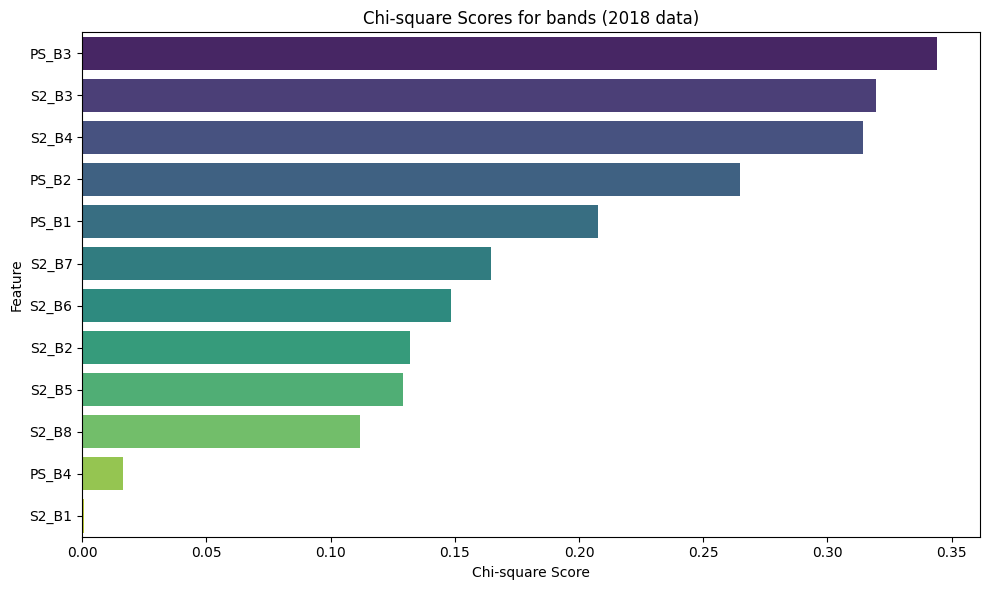

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd
import ee
import numpy as np # Import numpy for inf/nan handling
import matplotlib.pyplot as plt # Import for plotting
import seaborn as sns # Import for plotting

# Assume ee.Initialize() has been run
# Assume sampledData_2018 is your ee.FeatureCollection

# Convert the Earth Engine FeatureCollection to a list of dictionaries
try:
    data_2018_list = sampledData_2018.getInfo()['features']
except Exception as e:
    print(f"Error getting info from FeatureCollection: {e}")
    print("Please ensure sampledData_2018 is properly initialized and contains data.")
    data_2018_list = [] # Initialize empty list if there's an error

# Convert the list of dictionaries to a pandas DataFrame
if data_2018_list:
    # Extract the properties dictionary from each feature
    properties_list = [feature['properties'] for feature in data_2018_list]
    df_2018 = pd.DataFrame(properties_list)

    # Map 'seagrass' to 0 and 'sand' to 1 for the target variable
    df_2018['habitat'] = df_2018['Bottom'].map({'seagrass': 0, 'sand': 1})

    # Drop the original 'Bottom' column and any other irrelevant columns (like 'system:index' or geometry columns if present)
    cols_to_drop = ['Bottom', 'system:index'] # Add any other columns you don't want as features
    df_2018 = df_2018.drop(columns=[col for col in cols_to_drop if col in df_2018.columns])

    # --- Remove the specific variables by name ---
    variables_to_remove = ['PS_Kd_505', 'PS_KPAR', 'S2_SPM_Nechad2016_665', 'S2_chl_re_mishra']
    # Drop columns if they exist in the DataFrame
    df_2018 = df_2018.drop(columns=[col for col in variables_to_remove if col in df_2018.columns])
    # --------------------------------------------


    # Separate features (X) and target variable (y)
    # Ensure 'habitat' is the target and all other columns are features
    if 'habitat' in df_2018.columns:
        X = df_2018.drop('habitat', axis=1)
        y = df_2018['habitat']
    else:
        print("Error: 'habitat' column not found after removing variables.")
        X = pd.DataFrame() # Empty DataFrame if 'habitat' is missing
        y = pd.Series(dtype=float) # Empty Series if 'habitat' is missing


    # Chi-square works with non-negative values.
    # Spectral reflectance values can be negative after atmospheric correction or processing.
    # You might need to transform your data to be non-negative.
    # A common approach is to scale the data to a positive range or use absolute values.
    # For demonstration, we'll use absolute values. Consider if this is appropriate for your data.
    X = X.abs() # Example transformation

    # Handle potential NaN or infinite values that might arise from transformations or data issues
    X = X.replace([np.inf, -np.inf], np.nan).dropna()
    y = y[X.index] # Ensure y aligns with the filtered X

    # Proceed with feature selection only if X is not empty
    if not X.empty:
        # Create a SelectKBest instance with chi2 as the scoring function
        k_best_features = SelectKBest(score_func=chi2, k='all') # Use k='all' to see scores for all features

        # Fit the SelectKBest instance to your data
        k_best_features.fit(X, y)

        # Get the scores for each feature
        feature_scores = pd.DataFrame({'Feature': X.columns, 'Chi2_Score': k_best_features.scores_})

        # Sort the features by their Chi-square scores in descending order
        feature_scores = feature_scores.sort_values(by='Chi2_Score', ascending=False)

        print("Chi-square scores for features (2018 data) after removing specified variables:")
        print(feature_scores)

        # Plot results
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Chi2_Score', y='Feature', data=feature_scores, palette='viridis')
        plt.title('Chi-square Scores for bands (2018 data)')
        plt.xlabel('Chi-square Score')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    else:
        print("Cannot perform feature selection. Feature DataFrame is empty.")


else:
    print("Could not process sampledData_2018. DataFrame is empty.")

Chi-square analysis 2024

Chi-square scores for features (2024 data) after applying specified grouping:
   Feature  Chi2_Score
15   S2_B8    0.121198
14   S2_B7    0.093866
13   S2_B6    0.061626
7    PS_B8    0.047707
10   S2_B3    0.039411
8    S2_B1    0.021364
3    PS_B4    0.016156
4    PS_B5    0.015977
11   S2_B4    0.014067
2    PS_B3    0.008802
5    PS_B6    0.007976
9    S2_B2    0.004220
12   S2_B5    0.003786
1    PS_B2    0.002943
0    PS_B1    0.001945
6    PS_B7    0.000609


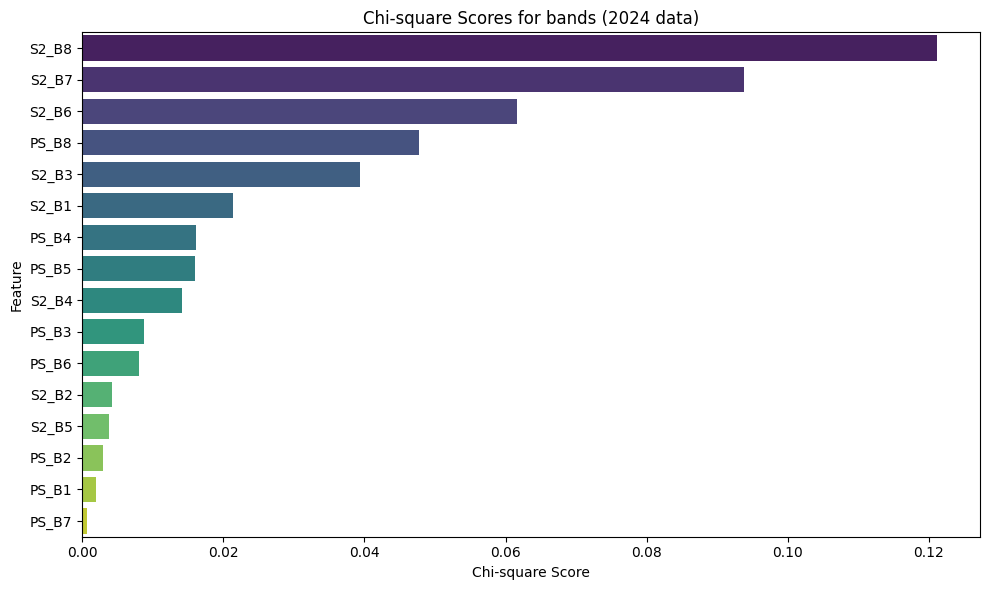

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd
import ee
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume ee.Initialize() has been run
# Assume sampledData_2024 is your ee.FeatureCollection

# Convert the Earth Engine FeatureCollection to a list of dictionaries
try:
    data_2024_list = sampledData_2024.getInfo()['features']
except Exception as e:
    print(f"Error getting info from FeatureCollection: {e}")
    print("Please ensure sampledData_2024 is properly initialized and contains data.")
    data_2024_list = []

# Convert the list of dictionaries to a pandas DataFrame
if data_2024_list:
    # Extract the properties dictionary from each feature
    properties_list = [feature['properties'] for feature in data_2024_list]
    df_2024 = pd.DataFrame(properties_list)

    # Map 'Halodule' and 'Ruppia' to 0 (seagrass) and 'sand' and 'mud' to 1 (non-seagrass)
    # Handle other values if necessary, perhaps map them to NaN and drop later
    df_2024['habitat'] = df_2024['Bottom'].map({'Halodule': 0, 'Ruppia': 0, 'sand': 1, 'mud': 1})

    # Drop the original 'Bottom' column and any other irrelevant columns (like 'system:index' or geometry columns if present)
    cols_to_drop = ['Bottom', 'system:index'] # Add any other columns you don't want as features
    df_2024 = df_2024.drop(columns=[col for col in cols_to_drop if col in df_2024.columns])

    # Remove rows where 'habitat' is NaN (for 'rock' or 'algae' if not included in mapping)
    df_2024 = df_2024.dropna(subset=['habitat'])

    # --- Remove the specific variables by name ---
    variables_to_remove = ['PS_Kd_492', 'PS_KPAR', 'S2_SPM_Nechad2016_665', 'S2_chl_re_mishra']
    # Drop columns if they exist in the DataFrame
    df_2024 = df_2024.drop(columns=[col for col in variables_to_remove if col in df_2024.columns])
    # --------------------------------------------

    # Separate features (X) and target variable (y)
    if 'habitat' in df_2024.columns:
        X = df_2024.drop('habitat', axis=1)
        y = df_2024['habitat'].astype(int) # Ensure y is integer type for chi2
    else:
        print("Error: 'habitat' column not found after removing variables.")
        X = pd.DataFrame()
        y = pd.Series(dtype=int)

    # Chi-square works with non-negative values.
    X = X.abs()

    # Handle potential NaN or infinite values
    X = X.replace([np.inf, -np.inf], np.nan).dropna()
    y = y[X.index]

    # Proceed with feature selection only if X is not empty
    if not X.empty and not y.empty:
        # Create a SelectKBest instance
        k_best_features = SelectKBest(score_func=chi2, k='all')

        # Fit the SelectKBest instance to your data
        k_best_features.fit(X, y)

        # Get the scores for each feature
        feature_scores = pd.DataFrame({'Feature': X.columns, 'Chi2_Score': k_best_features.scores_})

        # Sort the features by their Chi-square scores
        feature_scores = feature_scores.sort_values(by='Chi2_Score', ascending=False)

        print("Chi-square scores for features (2024 data) after applying specified grouping:")
        print(feature_scores)

        # Plot results
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Chi2_Score', y='Feature', data=feature_scores, palette='viridis')
        plt.title('Chi-square Scores for bands (2024 data)')
        plt.xlabel('Chi-square Score')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    else:
        print("Cannot perform feature selection. Feature or target DataFrame is empty after cleaning.")

else:
    print("Could not process sampledData_2024. DataFrame is empty.")

In [ ]:
# ## Attach Rrs values to obtain spectral signatures for each sensor
# dict_S2 = {
#     'S2_B1': '443',
#     'S2_B2': '492',
#     'S2_B3': '560',
#     'S2_B4': '666',
#     'S2_B5': '704',
#     'S2_B6': '740',
#     'S2_B7': '783',
#     'S2_B8': '834',
#     'S2_B8A': '866',
#     'S2_B9': '946',
#     'S2_B10': '1375',
#     'S2_B11': '1610',
#     'S2_B12': '2200'
# }

# dict_PS2 = {
#     'PS_B1': '485',
#     'PS_B2': '566',
#     'PS_B3': '665',
#     'PS_B4': '865',
# }

# dict_PSB_SD = {
#     'PS_B1': '444',
#     'PS_B2': '490',
#     'PS_B3': '531',
#     'PS_B4': '565',
#     'PS_B5': '610',
#     'PS_B6': '665',
#     'PS_B7': '705',
#     'PS_B8': '865',
# }

In [ ]:
# def sum_dicts(dict1, dict2):
#   result = dict1.copy()

#   for key, value in dict2.items():
#     if key in result:
#       # Use string concatenation to 'add' values if keys match
#       # result[key] += value  # Previous incorrect line
#       result[key] = str(result[key]) + str(value)
#     else:
#       result[key] = value  # Otherwise, add the key-value pair

#   return result

# dict_18 = sum_dicts(dict_S2, dict_PS2)
# dict_24 = sum_dicts(dict_S2, dict_PSB_SD)
# print(dict_24)

# # Remove keys from dict_18 that are not in sampledData_2018
# # Get the property names from the first feature in sampledData_2024
# property_names = sampledData_2018.first().propertyNames().getInfo()

# # Filter dict_24 to keep only keys present in property_names
# dict_18_filtered = {key: value for key, value in dict_18.items() if key in property_names}
# print(dict_18_filtered)

# # Function to rename properties of a feature
# def rename_properties(feature):
#   # Get the original properties
#   properties = feature.toDictionary()

#   # Convert dict_24_filtered to an ee.Dictionary
#   ee_dict_18 = ee.Dictionary(dict_18_filtered)

#   # Get the keys (original names) and values (new names) from dict_24_filtered
#   from_names = list(dict_18_filtered.keys())
#   to_names = list(dict_18_filtered.values())

#   # Rename properties using from_names and to_names
#   renamed_properties = properties.rename(from_names, to_names)

#   # Return the feature with renamed properties
#   return feature.set(renamed_properties)

# # Apply the renaming function to the FeatureCollection
# renamed_sampledData_2018 = sampledData_2018.map(rename_properties)
# # renamed_sampledData_2024.first().propertyNames().getInfo()
# renamed_sampledData_2018



# # Remove keys from dict_24 that are not in sampledData_2024
# # Get the property names from the first feature in sampledData_2024
# property_names = sampledData_2024.first().propertyNames().getInfo()

# # Filter dict_24 to keep only keys present in property_names
# dict_24_filtered = {key: value for key, value in dict_24.items() if key in property_names}
# print(dict_24_filtered)

# # Function to rename properties of a feature
# def rename_properties(feature):
#   # Get the original properties
#   properties = feature.toDictionary()

#   # Convert dict_24_filtered to an ee.Dictionary
#   ee_dict_24 = ee.Dictionary(dict_24_filtered)

#   # Get the keys (original names) and values (new names) from dict_24_filtered
#   from_names = list(dict_24_filtered.keys())
#   to_names = list(dict_24_filtered.values())

#   # Rename properties using from_names and to_names
#   renamed_properties = properties.rename(from_names, to_names)

#   # Return the feature with renamed properties
#   return feature.set(renamed_properties)

# # Apply the renaming function to the FeatureCollection
# renamed_sampledData_2024 = sampledData_2024.map(rename_properties)
# # renamed_sampledData_2024.first().propertyNames().getInfo()
# # renamed_sampledData_2024

In [ ]:
# # Export the FeatureCollection to Google Drive
# task = ee.batch.Export.table.toDrive(
#     collection=sampledData_2018_RH,
#     description='Signature_sampledData_2018_RH_OSW',  # Description for the task
#     folder='Colab_Notebooks/export',  # Replace with your desired folder in Google Drive
#     fileFormat='CSV'  # Choose your desired file format (CSV, GeoJSON, KML, SHP, TFRecord)
# )

# # Start the export task
# task.start()

# print('Export task started. You can monitor its progress in the "Tasks" tab.')

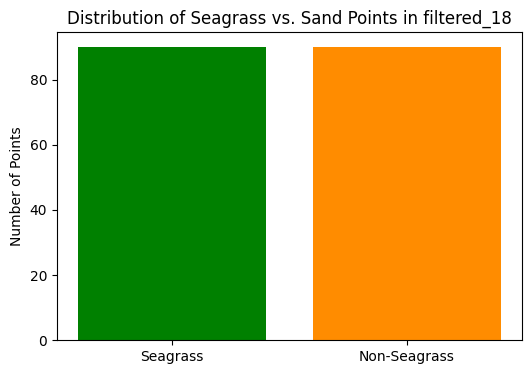

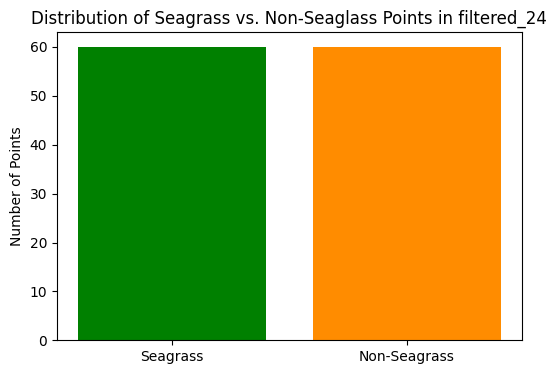

In [ ]:
## Split training and validation sets ## Be sure in a Random Forest that the dataset is balanced (50%/50% of each class)
## 2018
filtered_18_seagrass = insitu2018.filter(ee.Filter.eq('Bottom', 'seagrass')).randomColumn('random')
filtered_18_nonSeagrass = insitu2018.filter(ee.Filter.eq('Bottom', 'sand')).randomColumn('random')

# Get the count of seagrass and sand points in filtered_18
seagrass_samples_18 = filtered_18_seagrass.limit(90)
nonSeagrass_samples_18 = filtered_18_nonSeagrass.limit(90)

seagrass_count_18 = seagrass_samples_18.size().getInfo()
nonSeagrass_count_18 = nonSeagrass_samples_18.size().getInfo()

# Create labels and counts for the bar chart
labels = ['Seagrass', 'Non-Seagrass']
counts = [seagrass_count_18, nonSeagrass_count_18]

# Create the bar chart
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['green', 'darkorange'])
plt.ylabel('Number of Points')
plt.title('Distribution of Seagrass vs. Sand Points in filtered_18')
plt.show()

## 2024
filtered_24_seagrass = insitu2024.filter(ee.Filter.inList('Bottom', ['Hadolule', 'Ruppia'])).randomColumn('random')
filtered_24_nonSeagrass = insitu2024.filter(ee.Filter.inList('Bottom', ['sand',  'mud'])).randomColumn('random')

## 2024
# Separate features by class groupings
seagrass_samples_24 = filtered_24_seagrass.filter(ee.Filter.inList('Bottom', ['Hadolule', 'Ruppia'])).limit(60)
nonSeagrass_samples_24 = filtered_24_nonSeagrass.filter(ee.Filter.inList('Bottom', ['sand',  'mud', 'rock', 'algae'])).limit(60) # Adjust this list based on your non-seagrass classes

# Get the count of seagrass and non-seagrass points in filtered_24
seagrass_count_24 = seagrass_samples_24.size().getInfo()
nonSeagrass_count_24 = nonSeagrass_samples_24.size().getInfo()

# Create labels and counts for the bar chart
labels = ['Seagrass', 'Non-Seagrass']
counts = [seagrass_count_24, nonSeagrass_count_24]

# Create the bar chart
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['green', 'darkorange'])
plt.ylabel('Number of Points')
plt.title('Distribution of Seagrass vs. Non-Seaglass Points in filtered_24')
plt.show()

In [ ]:
## Split training and validation sets
## 2018
t_seagrass_pre = seagrass_samples_18.filter(ee.Filter.eq('Bottom', 'seagrass')).filter(ee.Filter.lt('random', 0.7))
v_seagrass_pre = seagrass_samples_18.filter(ee.Filter.eq('Bottom', 'seagrass')).filter(ee.Filter.gte('random', 0.7))
t_nonSeagrass_pre = nonSeagrass_samples_18.filter(ee.Filter.eq('Bottom', 'sand')).filter(ee.Filter.lt('random', 0.7))
v_nonSeagrass_pre = nonSeagrass_samples_18.filter(ee.Filter.eq('Bottom', 'sand')).filter(ee.Filter.gte('random', 0.7))
validation_pre = v_seagrass_pre.merge(v_nonSeagrass_pre)
print('Training pre:', t_seagrass_pre.merge(t_nonSeagrass_pre).size().getInfo())
print('t_seagrass_pre:', t_seagrass_pre.size().getInfo())
print('t_nonSeagrass_pre:', t_nonSeagrass_pre.size().getInfo())
print('Validation pre:', validation_pre.size().getInfo())
print('v_seagrass_pre:', v_seagrass_pre.size().getInfo())
print('v_nonSeagrass_pre:', v_nonSeagrass_pre.size().getInfo())

## 2024
t_seagrass_post = seagrass_samples_24.filter(ee.Filter.inList('Bottom', ['Hadolule', 'Ruppia'])).filter(ee.Filter.lt('random', 0.7))
v_seagrass_post = seagrass_samples_24.filter(ee.Filter.inList('Bottom', ['Hadolule', 'Ruppia'])).filter(ee.Filter.gte('random', 0.7))
t_nonSeagrass_post = nonSeagrass_samples_24.filter(ee.Filter.inList('Bottom', ['sand',  'mud'])).filter(ee.Filter.lt('random', 0.7)) ##['sand', 'rock', 'mud', 'algae']))
v_nonSeagrass_post = nonSeagrass_samples_24.filter(ee.Filter.inList('Bottom', ['sand', 'mud'])).filter(ee.Filter.gte('random', 0.7)) ## Try including only sand and mud
validation_post = v_seagrass_post.merge(v_nonSeagrass_post)
print('Training post:', t_seagrass_post.merge(t_nonSeagrass_post).size().getInfo())
print('t_seagrass_post:', t_seagrass_post.size().getInfo())
print('t_nonSeagrass_post:', t_nonSeagrass_post.size().getInfo())
print('Validation post:', v_seagrass_post.merge(v_nonSeagrass_post).size().getInfo())
print('v_seagrass_post:', v_seagrass_post.size().getInfo())
print('v_nonSeagrass_post:', v_nonSeagrass_post.size().getInfo())

Training pre: 126
t_seagrass_pre: 61
t_nonSeagrass_pre: 65
Validation pre: 54
v_seagrass_pre: 29
v_nonSeagrass_pre: 25
Training post: 89
t_seagrass_post: 42
t_nonSeagrass_post: 47
Validation post: 31
v_seagrass_post: 18
v_nonSeagrass_post: 13


In [ ]:
multi_sensor_post

# 5 - Depth Invariant Index (DII) - band ratios

In [ ]:
def S2_depthInvariant_pre(image):
  band1 = ['S2_B1', 'S2_B2', 'S2_B1']
  band2 = ['S2_B2', 'S2_B3', 'S2_B3']
  nband = ['S2_B1B2', 'S2_B2B3', 'S2_DII']

  for i in range(3):
    x = band1[i]
    y = band2[i]
    z = nband[i]

    imageLog = image.select([x, y]).log()

    sand = insitu2018.filter(ee.Filter.eq('Bottom', 'sand'))

    covariance = imageLog.toArray().reduceRegion(
        reducer=ee.Reducer.covariance(),
        geometry=sand,
        scale=3,
        maxPixels=1e13,
        bestEffort=True
    )

    covarMatrix = ee.Array(covariance.get('array'))
    var1 = covarMatrix.get([0, 0])
    var2 = covarMatrix.get([1, 1])
    covar = covarMatrix.get([0, 1])

    a = (var1.subtract(var2)).divide(covar.multiply(2))
    attenCoeffRatio = a.add(((a.pow(2)).add(1)).sqrt())

    depthInvariantIndex = image.expression(
        'image1 - (image2 * coeff)', {
            'image1': imageLog.select([x]),
            'image2': imageLog.select([y]),
            'coeff': attenCoeffRatio
        }
    )

    image = image.addBands(depthInvariantIndex.select([x], [z]))

  return image

def S2_depthInvariant_post(image):
  band1 = ['S2_B1', 'S2_B2', 'S2_B1']
  band2 = ['S2_B2', 'S2_B3', 'S2_B3']
  nband = ['S2_B1B2', 'S2_B2B3', 'S2_DII']

  for i in range(3):
    x = band1[i]
    y = band2[i]
    z = nband[i]

    imageLog = image.select([x, y]).log()

    sand = insitu2024.filter(ee.Filter.eq('Bottom', 'sand'))

    covariance = imageLog.toArray().reduceRegion(
        reducer=ee.Reducer.covariance(),
        geometry=sand,
        scale=3,
        maxPixels=1e13,
        bestEffort=True
    )

    covarMatrix = ee.Array(covariance.get('array'))
    var1 = covarMatrix.get([0, 0])
    var2 = covarMatrix.get([1, 1])
    covar = covarMatrix.get([0, 1])

    a = (var1.subtract(var2)).divide(covar.multiply(2))
    attenCoeffRatio = a.add(((a.pow(2)).add(1)).sqrt())

    depthInvariantIndex = image.expression(
        'image1 - (image2 * coeff)', {
            'image1': imageLog.select([x]),
            'image2': imageLog.select([y]),
            'coeff': attenCoeffRatio
        }
    )

    image = image.addBands(depthInvariantIndex.select([x], [z]))

  return image

# For PlanetScope Classic
def PSC_depthInvariant(image):
  band1 = ['PS_B1', 'PS_B2', 'PS_B1']
  band2 = ['PS_B2', 'PS_B3', 'PS_B2']
  nband = ['PS_B1B2', 'PS_B2B3', 'PS_DII']

  for i in range(3):
    x = band1[i]
    y = band2[i]
    z = nband[i]

    imageLog = image.select([x, y]).log()

    sand = insitu2018.filter(ee.Filter.eq('Bottom', 'sand'))

    covariance = imageLog.toArray().reduceRegion(
        reducer=ee.Reducer.covariance(),
        geometry=sand,
        scale=3,
        maxPixels=1e13,
        bestEffort=True
    )

    covarMatrix = ee.Array(covariance.get('array'))
    var1 = covarMatrix.get([0, 0])
    var2 = covarMatrix.get([1, 1])
    covar = covarMatrix.get([0, 1])

    a = (var1.subtract(var2)).divide(covar.multiply(2))
    attenCoeffRatio = a.add(((a.pow(2)).add(1)).sqrt())

    depthInvariantIndex = image.expression(
        'image1 - (image2 * coeff)', {
            'image1': imageLog.select([x]),
            'image2': imageLog.select([y]),
            'coeff': attenCoeffRatio
        }
    )

    image = image.addBands(depthInvariantIndex.select([x], [z]))

  return image

# For PlanetScope SuperDove
def PSSD_depthInvariant(image):
  band1 = ['PS_B2', 'PS_B3', 'PS_B2']
  band2 = ['PS_B3', 'PS_B4', 'PS_B4']
  nband = ['PS_B2B3', 'PS_B3B4', 'PS_DII']

  for i in range(3):
    x = band1[i]
    y = band2[i]
    z = nband[i]

    imageLog = image.select([x, y]).log()

    sand = insitu2024.filter(ee.Filter.eq('Bottom', 'sand'))

    covariance = imageLog.toArray().reduceRegion(
        reducer=ee.Reducer.covariance(),
        geometry=sand,
        scale=3,
        maxPixels=1e13,
        bestEffort=True
    )

    covarMatrix = ee.Array(covariance.get('array'))
    var1 = covarMatrix.get([0, 0])
    var2 = covarMatrix.get([1, 1])
    covar = covarMatrix.get([0, 1])

    a = (var1.subtract(var2)).divide(covar.multiply(2))
    attenCoeffRatio = a.add(((a.pow(2)).add(1)).sqrt())

    depthInvariantIndex = image.expression(
        'image1 - (image2 * coeff)', {
            'image1': imageLog.select([x]),
            'image2': imageLog.select([y]),
            'coeff': attenCoeffRatio
        }
    )

    image = image.addBands(depthInvariantIndex.select([x], [z]))

  return image

# Apply to your image collection (e.g., multi_sensor_pre or multi_sensor_post)
multi_sensor_pre = multi_sensor_pre.map(S2_depthInvariant_pre).map(PSC_depthInvariant)
multi_sensor_post = multi_sensor_post.map(S2_depthInvariant_post).map(PSSD_depthInvariant)

In [ ]:
# ## NDAVI index
# # Function to calculate NDAVI and add it as a band
# def S2_ndavi(image):
#     ndavi = image.normalizedDifference(['S2_B8', 'S2_B2']).rename('S2_NDAVI')
#     return image.addBands(ndavi)

# def PSC_ndavi(image):
#     ndavi = image.normalizedDifference(['PS_B4', 'PS_B1']).rename('PS_NDAVI')
#     return image.addBands(ndavi)

# def PSSD_ndavi(image):
#     ndavi = image.normalizedDifference(['PS_B8', 'PS_B2']).rename('PS_NDAVI')
#     return image.addBands(ndavi)

# # Map function over collection
# multi_sensor_pre = multi_sensor_pre.map(S2_ndavi).map(PSC_ndavi)
# multi_sensor_post = multi_sensor_post.map(S2_ndavi).map(PSSD_ndavi)

# 6 - Binary classification

## 6.1 - Pre-event Multi-sensor Image Collection
#### Before processing all data, the best seagrass probability threshold was studied and set as t = 45

In [ ]:
# Binary classification setup
seagrass_class = 0
nonSeagrass_class = 1

# Classification and validation parameters
trees = 50
t = 45

# Boxcar kernel: a square matrix where all values are equal, and it calculates the mean of the pixel values within that square neighborhood.
boxcar = ee.Kernel.square(radius=2, units='pixels', normalize=True)
bands = multi_sensor_pre.first().bandNames()

def boxcar_image(image):
    return image.convolve(boxcar)

# Apply the function to every image in the collection
classificationComp_pre = multi_sensor_pre.map(boxcar_image)
classificationComp_pre

 ##### 6.1.1 - Prepare training dataset

In [ ]:
# Training data - class property recoding and merging - MODEL 1 (PRE-EVENT)
t_seagrass = t_seagrass_pre.map(lambda x: x.setMulti(ee.Dictionary.fromLists(['habitat'], [seagrass_class])))
t_nonSeagrass = t_nonSeagrass_pre.map(lambda x: x.setMulti(ee.Dictionary.fromLists(['habitat'], [nonSeagrass_class])))
t_FC = t_seagrass.merge(t_nonSeagrass)


# Collect sampled features from each image
def sample_image(image):
    sampled = image.sampleRegions(
        collection=t_FC,
        scale=3,
        geometries=True
    ).filter(ee.Filter.notNull(bands))

    return sampled

# Map the sampling function and convert result to a list of FeatureCollections
sampled_fc_list = classificationComp_pre.map(sample_image).toList(classificationComp_pre.size())
sampled_fc_list
# Flatten the FeatureCollections into one big FeatureCollection
sampledData = ee.FeatureCollection(sampled_fc_list).flatten()

# Using sampleRegions we take values across the Image Collection. getting valid FeatureCollection when overlapping with pixels
print('sampledData:', sampledData.size().getInfo())
print('t_FC:', t_FC.size().getInfo())

sampledData: 342
t_FC: 126


6.1.2 - Extract probabilities for each class and train classifier

{'PS_B1': 15.573189461454858, 'PS_B1B2': 10.957696731717604, 'PS_B2': 11.69282147879875, 'PS_B2B3': 13.255050874489411, 'PS_B3': 13.653616646630459, 'PS_B4': 14.222714838812239, 'PS_DII': 10.956284024895504, 'PS_KPAR': 16.860783600210876, 'PS_Kd_505': 10.760508556134205, 'S2_B1': 16.358087768655725, 'S2_B1B2': 12.481554829553929, 'S2_B2': 11.274383432479858, 'S2_B2B3': 10.27771213113595, 'S2_B3': 8.905000824904894, 'S2_B4': 10.679036338311745, 'S2_B5': 9.440365339714836, 'S2_B6': 8.875698683653285, 'S2_B7': 11.93810260230047, 'S2_B8': 8.85906977799912, 'S2_DII': 15.102901830397707, 'S2_SPM_Nechad2016_665': 10.595079690327433, 'S2_chl_re_mishra': 14.811979476846725}


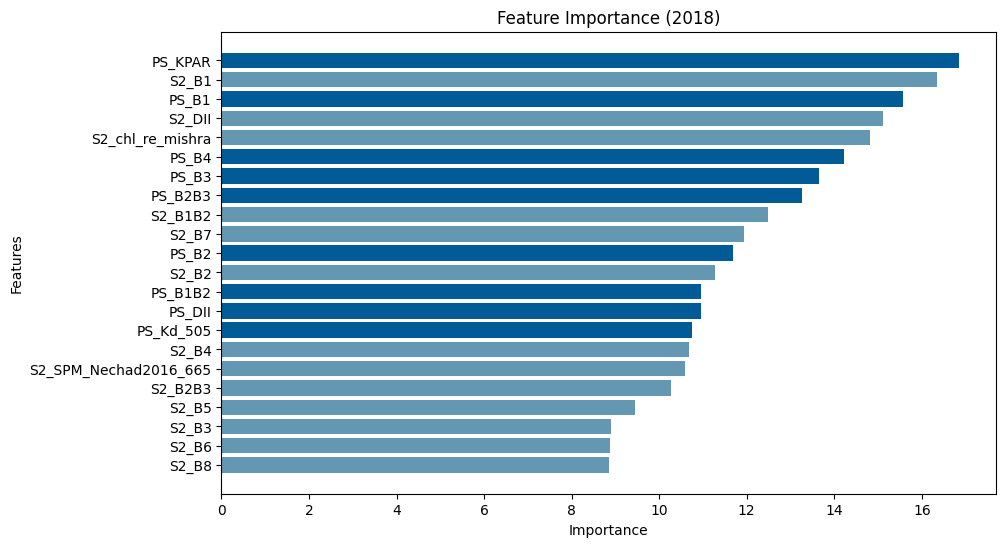

Selected bands: ['PS_B1', 'PS_B1B2', 'PS_B2', 'PS_B2B3', 'PS_B3', 'PS_B4', 'PS_DII', 'PS_KPAR', 'PS_Kd_505', 'S2_B1', 'S2_B1B2', 'S2_B2', 'S2_B2B3', 'S2_B3', 'S2_B4', 'S2_B5', 'S2_B6', 'S2_B7', 'S2_B8', 'S2_DII', 'S2_SPM_Nechad2016_665', 'S2_chl_re_mishra']


<Figure size 640x480 with 0 Axes>

In [ ]:
## To extract feature importance and evaluate
def soft_prob_subfn(image, num):
       training = sampledData.map(lambda ft: ft.set(
        'prob',
        ee.Algorithms.If(ft.getNumber('habitat').eq(num), 1, 0)
        ))

       trained = ee.Classifier.smileRandomForest(numberOfTrees=trees) \
           .train(training, 'prob', image.bandNames()) \
           .setOutputMode('PROBABILITY')

       dict_classifier = trained.explain()

       # Create a Feature with the dictionary as a property
       feature = ee.Feature(None, {'classifier_explanation': dict_classifier})

       # Classify and convert to percentage scale
       classified = image.classify(trained).multiply(100).toInt8()

       # Return both the classified image and the Feature with explanation
       return ee.Image(classified).set('classifier_explanation', feature)

# Map the function to your ImageCollection
seagrass_prob_IC = classificationComp_pre.map(lambda img: soft_prob_subfn(img, seagrass_class))
nonSeagrass_prob_IC = classificationComp_pre.map(lambda img: soft_prob_subfn(img, nonSeagrass_class))


### MEAN FEATURE IMPORTANCE
# Get the first three images from the ImageCollection
first_three_images = seagrass_prob_IC.toList(3)

# Initialize an empty dictionary to store feature importances
mean_importance = {}

# Iterate through the first three images
for i in range(3):
  image = ee.Image(first_three_images.get(i))
  classifier_explanation = image.get('classifier_explanation').getInfo()['properties']['classifier_explanation']
  importance_dict = classifier_explanation.get('importance')

  # Accumulate feature importances
  for feature, importance in importance_dict.items():
    mean_importance[feature] = mean_importance.get(feature, 1) + importance

# Calculate the mean feature importance
for feature in mean_importance:
  mean_importance[feature] /= 3

# Print the mean feature importance
print(mean_importance)

# Sort features by importance in descending order
sorted_importance = dict(sorted(mean_importance.items(), key=lambda item: item[1], reverse=False))

# Extract feature names and importance values
feature_names = list(sorted_importance.keys())
importance_values = list(sorted_importance.values())

# Create a list of colors based on feature name prefix
colors = ['#005b96' if name.startswith('PS_') else '#6497b1' for name in feature_names]

# Create the horizontal bar graph (switched axes)
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.barh(feature_names, importance_values, color=colors) # Changed to barh for horizontal bars
plt.ylabel("Features") # Switched x and y labels
plt.xlabel("Importance") # Switched x and y labels
plt.title("Feature Importance (2018)")
# plt.axvline(x=10.5, linestyle='dotted', color='grey')  # Add dotted vertical line
plt.savefig('feature_importance_2018.png', dpi=300, bbox_inches='tight')
plt.show()  # Display the plot
plt.tight_layout()

selected_bands = [band for band, importance in mean_importance.items() if importance >= 0] ## Use only selected bands for the classification ## 10.5 before

print("Selected bands:", selected_bands)

Analyse covariance between variables

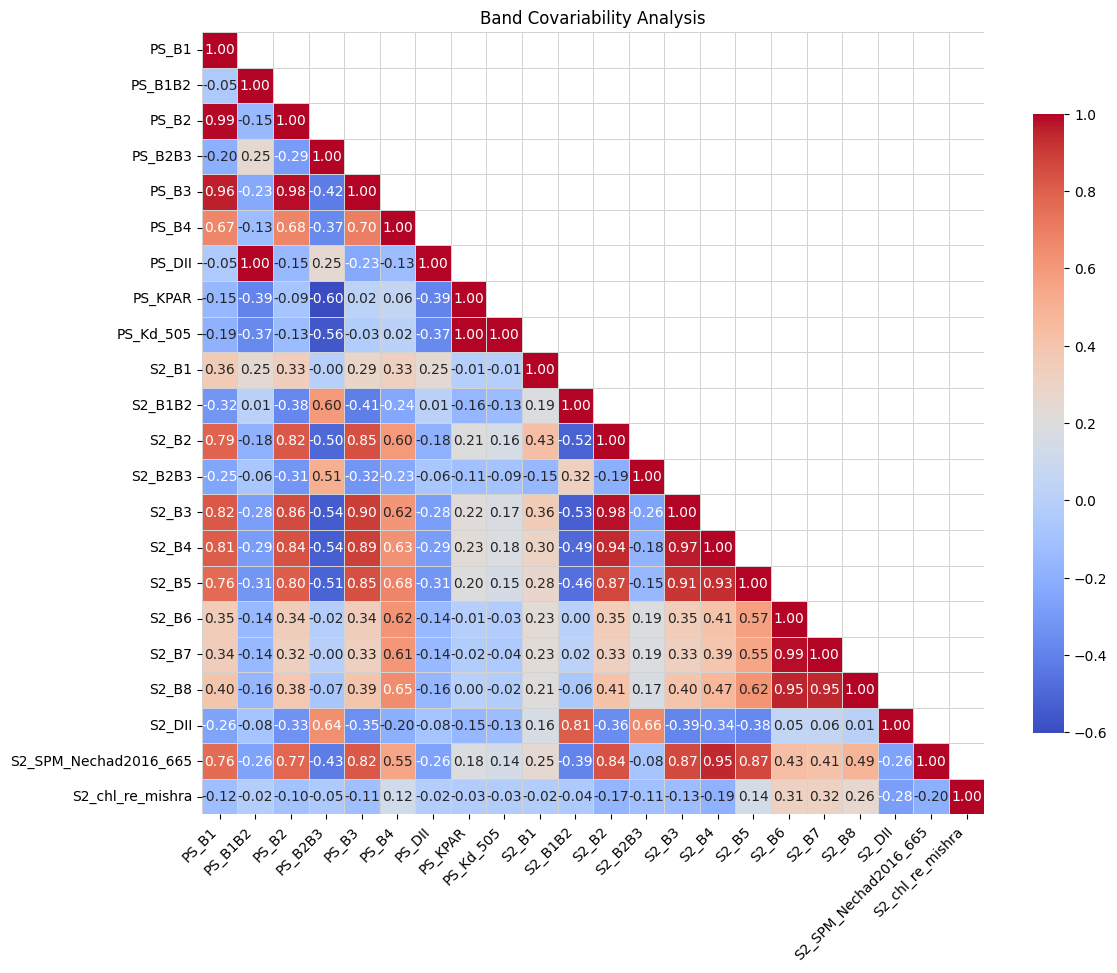

Bands to keep: ['PS_B1', 'PS_B1B2', 'PS_B2', 'PS_B2B3', 'PS_B3', 'PS_B4', 'PS_DII', 'PS_KPAR', 'PS_Kd_505', 'S2_B1', 'S2_B1B2', 'S2_B2', 'S2_B2B3', 'S2_B3', 'S2_B4', 'S2_B5', 'S2_B6', 'S2_B7', 'S2_B8', 'S2_DII', 'S2_SPM_Nechad2016_665', 'S2_chl_re_mishra']


In [ ]:
## Co-variance analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to extract band values from a FeatureCollection
def extract_band_values(feature_collection, bands):
    data = feature_collection.toList(feature_collection.size()).map(lambda feature: ee.Feature(feature).toDictionary().select(bands)).getInfo()
    df = pd.DataFrame(data)
    return df

# Extract band values for selected bands
band_values_df = extract_band_values(sampledData, selected_bands)

# Calculate the correlation matrix
correlation_matrix = band_values_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, bool), k=1)

# Apply the mask to the filtered correlation matrix
filtered_correlation_matrix = correlation_matrix.mask(mask)
filtered_correlation_matrix = filtered_correlation_matrix[np.abs(correlation_matrix) > 0.80]

# Get bands with at least one correlation above 0.9
bands_to_keep = filtered_correlation_matrix.columns[filtered_correlation_matrix.any()]

# Filter the original correlation matrix to keep only relevant bands
filtered_correlation_matrix = correlation_matrix.loc[bands_to_keep, bands_to_keep]

# Plot only the lower triangle of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
            fmt=".2f", linewidths=.5, linecolor='lightgrey', square=True,
            cbar_kws={"shrink": .75})
plt.title('Band Covariability Analysis')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Bands to keep:", bands_to_keep.tolist())

6.1.3 - Generate probability layers

In [ ]:
## Train classifier and display probability map for seagrasses
# Define classes dictionary
classes = {
  'classes_values': [seagrass_class, nonSeagrass_class],
  'classes_names': ['seagrass','nonSeagrass']
}

classes

def classify_with_all_classes(image):
    # Classify image for each class and rename the result accordingly
    classified_images = ee.List(classes['classes_values']).map(
        lambda class_id: soft_prob_subfn(image, class_id)
    )

    # Convert list of images into one multi-band image (each class as band)
    classified_combined = ee.ImageCollection(classified_images).toBands()
    classified_combined = classified_combined.rename(classes['classes_names'])

    # Preserve metadata if needed
    return classified_combined.copyProperties(image, image.propertyNames())

# Generate probabilities in the ImageCollection
probabilities_pre = classificationComp_pre.map(classify_with_all_classes)
probabilities_pre

Plot probabilities:

In [ ]:
# Visualize probabilities
first_prob = ee.Image(probabilities_pre.toList(probabilities_pre.size()).get(0))
Map = geemap.Map()
Map.addLayer(first_prob.select('seagrass'), {'min': 45, 'max': 100}, 'Seagrass Prob')
Map.addLayer(first_prob.select('nonSeagrass'), {'min': 45, 'max': 100}, 'NonSeagrass Prob')
Map.centerObject(probabilities_pre.first(), zoom=12)
Map

6.1.4 - Threshold classes based on probabilities and classify

In [ ]:
# Based on the generated probabilities, apply thresholding for seagrass and nonSeagrass on the whole Image Collection

# Threshold function for seagrass
def threshold_seagrass(image):
    return image.select('seagrass').updateMask(image.select('seagrass').gt(t)) \
        .copyProperties(image, image.propertyNames())

# Threshold function for non-seagrass
def threshold_non_seagrass(image):
    return image.select('nonSeagrass').updateMask(image.select('nonSeagrass').gt(t)) \
        .copyProperties(image, image.propertyNames())

# Map the thresholding over the probabilities collection
seagrass_soft = probabilities_pre.map(threshold_seagrass)
nonSeagrass_soft = probabilities_pre.map(threshold_non_seagrass)
nonSeagrass_soft

# Function to combine seagrass and nonSeagrass into one image
def add_bands(image):
    matching_non_seagrass = nonSeagrass_soft.filter(
        ee.Filter.eq('system:index', image.get('system:index'))
    ).first()

    # If no match is found, return image as-is
    combined = ee.Image(image).addBands(ee.Image(matching_non_seagrass))
    return combined.copyProperties(image, image.propertyNames())

# Map the function to seagrass_soft collection to create the aggregated collection
soft_map = seagrass_soft.map(add_bands)

6.1.5 - Perform classification

In [ ]:
def soft_to_hard(image):
    seagrass = image.select('seagrass')
    non_seagrass = image.select('nonSeagrass')
    prob_aoi = ee.Image(probabilities_pre.first()).geometry()

    # Get the corresponding images from seagrass_soft and nonSeagrass_soft using system:index
    seagrass_soft_image = seagrass_soft.filter(ee.Filter.eq('system:index', image.get('system:index'))).first()
    nonSeagrass_soft_image = nonSeagrass_soft.filter(ee.Filter.eq('system:index', image.get('system:index'))).first()

    classified = (ee.Image.constant(2)
        .where(seagrass.gte(t), ee.Number(0).add(1))  # temporary +1 to mask 0s
        .where(non_seagrass.gte(t), ee.Number(1).add(1))
        .selfMask()
        .subtract(1)  # back to 0 and 1
        .rename('classification')
        .clip(prob_aoi))

    return classified.copyProperties(image, image.propertyNames())

# Apply to soft_map
soft_map_th = soft_map.map(soft_to_hard)

In [ ]:
# ## Export
# image_to_export = soft_map_th.first()
# # Define the export task
# task = ee.batch.Export.image.toDrive(
#     image=image_to_export,
#     description='soft_map_th_first',  # Description for the task
#     folder='Colab_Notebooks/export',  # Folder in Google Drive to save the image
#     fileNamePrefix='soft_map_th_first',  # Prefix for the file name
#     region=roi,  # Region of interest
#     scale=3,  # Scale in meters
#     fileFormat='GeoTIFF',  # File format
#     maxPixels=1e13  # Maximum number of pixels allowed (adjust if needed)
# )
# # Start the export task
# task.start()
# print('Export task started. You can monitor its progress in the "Tasks" tab.')

6.1.6 - Combine the three classifications for visualization

In [ ]:
# 1. Extract the 'classification' band from each image
classification_images_pre = soft_map_th.select('classification')

# 2. Calculate the mean value
combined_classification_pre = classification_images_pre.mean().mask(land_mask).clip(OSW) #.selfMask()
# print(combined_classification.getInfo())

# Display the combined classification
Map.addLayer(combined_classification_pre, {'min': 0, 'max': 1, 'palette': ['42762f', '7cb75a', 'e2e9ab', 'ffffff']}, 'Combined Classification')
Map

In [ ]:
# # Export the FeatureCollection to Google Drive
# task = ee.batch.Export.image.toDrive(
#     image=combined_classification_pre,
#     description='combined_classification_pre',  # Description for the task
#     folder='Colab_Notebooks/export',
#     region = OSW.geometry(),
#     scale=3,  # Adjust the scale as needed
#     fileFormat='GeoTIFF'  # Choose your desired file format (CSV, GeoJSON, KML, SHP, TFRecord)
# )

# # Start the export task
# task.start()

# print('Export task started. You can monitor its progress in the "Tasks" tab.')

In [ ]:
# Apply conditional classification for obtain the final binary map
final_classification_pre = combined_classification_pre.expression(
    'b(0) < 0.35 ? 0 : 1',  # Conditional expression
    {'classification': combined_classification_pre}  # Band name mapping
).rename('classification')  # Rename the band

# Display the combined classification
Map.addLayer(final_classification_pre.mask(land_mask).clip(OSW.geometry()), {'min': 0, 'max': 1, 'palette': ['42762f', 'ffffff']}, 'Combined Classification')

6.1.7 - Validation and accuracy assessment for each of the 3 classifications

In [ ]:
# Validation function
def valid_habitat(number):
  def wrap(feature):
    return feature.setMulti(ee.Dictionary.fromLists(['habitat'], [number]))
  return wrap

## Validation data
v_seagrass = v_seagrass_pre.map(valid_habitat(seagrass_class))
v_nonSeagrass = v_nonSeagrass_pre.map(valid_habitat(nonSeagrass_class))
v_FC = v_seagrass.merge(v_nonSeagrass)
v_FC

In [ ]:
# Collect sampled features from each image
def validation(image):
    # Buffer the validation points by 10 meters (optional, keep if desired)
   # buffered_v_FC = v_FC.map(lambda feature: feature.buffer(5))

    sampled = image.sampleRegions(
        collection=v_FC,
        properties=['habitat'],
        scale=3
        )
    return sampled


# Map the sampling function and convert result to a list of FeatureCollections
sampled_v_list = soft_map_th.map(validation).toList(soft_map_th.size())

# Flatten the FeatureCollections into one big FeatureCollection
sampledValidation_pre = ee.FeatureCollection(sampled_v_list).flatten() #.filter(ee.Filter.notNull(['habitat']))

## To validate with the final combination of the 3 classifications (this will be better)
# sampledValidation_pre = final_classification_pre.sampleRegions(
#     collection=v_FC,
#     scale=3,
#     properties=['habitat'])

# Using sampleRegions we take values across the Image Collection. getting valid FeatureCollection when overlapping with pixels
print('sampled Validation:', sampledValidation_pre.size().getInfo())
sampledValidation_pre

sampled Validation: 162


Confusion Matrix: [[62, 25], [10, 65]]


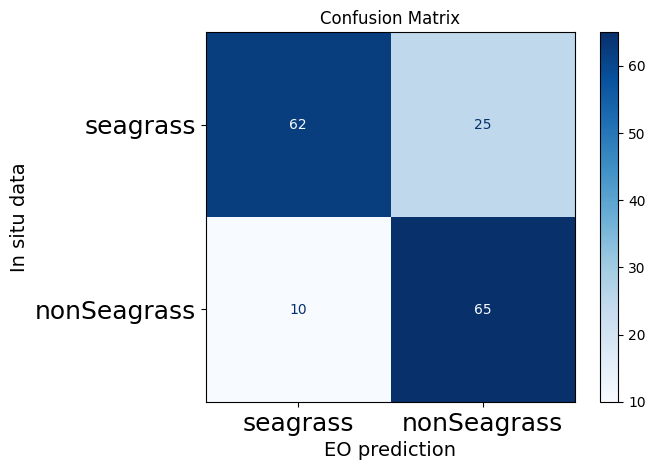

Overall Accuracy: 0.7839506172839507
PA: [0.7126436781609196, 0.8666666666666667]
UA: [0.8611111111111112, 0.7222222222222222]
F1-score: 0.779874213836478


In [ ]:
errorMatrix = sampledValidation_pre.errorMatrix('habitat', 'classification')
print('Confusion Matrix:', errorMatrix.getInfo())

# Get confusion matrix data as a list of lists
confusion_matrix_data = errorMatrix.array().getInfo()

# Convert the list to a NumPy array
matrix_values = np.array(confusion_matrix_data)  # Convert to NumPy array

# Define class labels
class_names = ['seagrass', 'nonSeagrass']  # Adjust if your class names are different

# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=matrix_values, display_labels=class_names)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel("EO prediction", fontsize = 14)  # Change to your desired text
plt.ylabel("In situ data", fontsize = 14)
disp.ax_.tick_params(axis='both', which='major', labelsize=18)  # Increase axis tick label size  # Change to your desired text
plt.show()

# Print accuracy metrics
overall_accuracy = errorMatrix.accuracy().getInfo()
print('Overall Accuracy:', overall_accuracy)
producers_accuracy = ee.Array(errorMatrix.producersAccuracy()).reshape([-1]).getInfo()
print('PA:', producers_accuracy)
users_accuracy = ee.Array(errorMatrix.consumersAccuracy()).reshape([-1]).getInfo()
print('UA:', users_accuracy)

# Calcuate F1-score
# Extract the components from the confusion matrix
truePositives = errorMatrix.array().get([0, 0])
falsePositives = errorMatrix.array().get([1, 0])
falseNegatives = errorMatrix.array().get([0, 1])

# Calculate precision, recall, and F1-score
precision = truePositives.divide(truePositives.add(falsePositives))
recall = truePositives.divide(truePositives.add(falseNegatives))
f1_score = ee.Number(2).multiply(precision.multiply(recall)).divide(precision.add(recall))

print('F1-score:', f1_score.getInfo())

### Area quantification stats and +-

In [ ]:
# Mask seagrass pixels
seagrass_pre = final_classification_pre.eq(0)

# create a binary mask: 1 = seagrass, 0 = nonSeagrass
seagrass_mask = seagrass_pre.rename('seagrass')  # change eq(0) if your seagrass label differs

# count seagrass pixels (sum of 1s)
pixel_count = seagrass_mask.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=OSW.geometry(),
    scale=3, # 3 m pixels
    maxPixels=1e13
).get('seagrass').getInfo()

# convert to hectares: each pixel = 9 m2 -> 9/10000 = 0.0009 ha
area_ha_pre = pixel_count * 9.0 / 10000.0

print(f"Seagrass pixels: {pixel_count}, area: {area_ha_pre} ha")

Seagrass pixels: 259973.8156862746, area: 233.97643411764716 ha


In [ ]:
# Scale probabilities from 0-100 to 0-1
probabilities_pre = probabilities_pre.map(lambda image: image.divide(100))

# Sum the seagrass probabilities for pre-event images
sum_seagrass_probabilities_pre = probabilities_pre.select('seagrass').sum()
sum_seagrass_probabilities_pre

# Calculate the mean of the summed probabilities within the seagrass mask
mean_sum_prob_seagrass_pre = sum_seagrass_probabilities_pre.updateMask(seagrass_mask).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=OSW.geometry(),
    scale=3, # Use the same scale as classification
    maxPixels=1e13
).get('seagrass')

mean_sum_prob_seagrass_pre = ee.Number(mean_sum_prob_seagrass_pre)

overall_accuracy_pre = ee.Number(overall_accuracy) # Use the overall_accuracy from the pre-event validation cell

total_seagrass_area_pre = ee.Number(area_ha_pre)


# Calculate uncertainty for the pre-event seagrass area using the provided formula:
# uncertainty = area * Overall Accuracy * (3 - mean of the sum of the probabilities predicted as seagrass) / 3
# Assuming '3' is the number of images used in the pre-event period (sentinel2_l1c_pre has 3 images)
num_images_pre = ee.Number(sentinel2_l1c_pre.size()) # Get the actual number of pre-event images

uncertainty_pre_seagrass_area = total_seagrass_area_pre.multiply(overall_accuracy_pre).multiply(num_images_pre.subtract(mean_sum_prob_seagrass_pre)).divide(num_images_pre)

print(f"Uncertainty of pre-event seagrass area: {area_ha_pre} +- {uncertainty_pre_seagrass_area.getInfo():.2f} ha")

Uncertainty of pre-event seagrass area: 233.97643411764716 +- 61.67 ha


6.1.8 - Uncertainty analysis

In [ ]:
# ## To run uncertainties in the first classification (pre-event, 2018)
# ## t=(9*OA*(3-median probabilities))/3
# # 9 = area of pixel in square meters (3x3)
# # 3 = number of images

# ## first scale probabilities to 0-1 values
# def scale_to_unit(image):
#     return image.divide(100).copyProperties(image, image.propertyNames())

# # Apply the scaling function to the collection
# probabilities_01 = probabilities.map(scale_to_unit)

# median_probability = probabilities_01.select('seagrass').median().rename('seagrass_median_prob')
# median_probability

# # Select the band containing median probability
# median_probability = median_probability.select('seagrass_median_prob')

# # Apply the formula:
# # uncertainty = (9 * overall_accuracy * (3 - median_probability)) / 3
# three = ee.Number(3)
# nine = ee.Number(9)
# oa = ee.Number(overall_accuracy)

# # Compute: (3 - median_prob)
# diff = ee.Image.constant().subtract(median_probability)

# # Continue: (9 * overall_accuracy * diff) / 3
# # uncertainty = (diff.multiply(oa).multiply(nine)).divide(three)
# uncertainty = diff.divide(oa)

# # Add the uncertainty as a new band
# uncertainty_pre = image.addBands(uncertainty.rename('uncertainty'))

# region = uncertainty_pre.geometry()
# # Calculate min and max of the uncertainty band
# stats = uncertainty_pre.select('uncertainty').reduceRegion(
#     reducer=ee.Reducer.minMax(),
#     geometry=region,
#     scale=3,
#     maxPixels=1e9
# )

# # Get the results
# min_val = stats.get('uncertainty_min').getInfo()
# max_val = stats.get('uncertainty_max').getInfo()

# print('Uncertainty range:', min_val, 'to', max_val)


# # ###########################

# # Select the uncertainty band
# uncertainty_pre = uncertainty_pre.select('uncertainty')

# # Normalize to 0–1
# normalized_uncertainty = uncertainty.subtract(min_val).divide(max_val - min_val)

# # Add it back to the image
# overlap_mask = combined_classification_pre.mask().reduce(ee.Reducer.anyNonZero())
# uncertainty_pre_norm = image.addBands(normalized_uncertainty.rename('uncertainty_norm'))

# region = uncertainty_pre_norm.geometry()
# # Calculate min and max of the uncertainty band
# stats2 = uncertainty_pre_norm.select('uncertainty_norm').reduceRegion(
#     reducer=ee.Reducer.minMax(),
#     geometry=region,
#     scale=3,
#     maxPixels=1e9
# )

# # Get the results
# min_val = stats2.get('uncertainty_norm_min').getInfo()
# max_val = stats2.get('uncertainty_norm_max').getInfo()

# print('Uncertainty range norm:', min_val, 'to', max_val)

# # Visualize the mean uncertainty layer
# # Define visualization parameters for the uncertainty band
# # You may need to adjust the min/max values based on your data range
# vis_params = {'bands': ['uncertainty_norm'], 'palette': ['#4d004b', '#4f004d', '#50014e', '#520150', '#540251', '#550253', '#570354', '#580356', '#5a0457', '#5c0459', '#5d055a', '#5f055c', '#61065d', '#62065f', '#640761', '#650762', '#670864', '#690865', '#6a0867', '#6c0968', '#6e096a', '#6f0a6b', '#710a6d', '#730b6e', '#740b70', '#760c71', '#770c73', '#790d75', '#7b0d76', '#7c0e78', '#7e0e79', '#800f7b', '#810f7c', '#81117d', '#81127e', '#82147f', '#821580', '#821781', '#821982', '#831a83', '#831c84', '#831d85', '#831f86', '#832088', '#842289', '#84248a', '#84258b', '#84278c', '#85288d', '#852a8e', '#852b8f', '#852d90', '#852f91', '#863092', '#863293', '#863394', '#863595', '#873696', '#873897', '#873a98', '#873b99', '#873d9a', '#883e9b', '#88409c', '#88419d', '#88439e', '#88449e', '#88459f', '#8947a0', '#8948a0', '#8949a1', '#894ba2', '#894ca2', '#894da3', '#894fa3', '#8950a4', '#8a51a5', '#8a52a5', '#8a54a6', '#8a55a7', '#8a56a7', '#8a58a8', '#8a59a8', '#8a5aa9', '#8b5caa', '#8b5daa', '#8b5eab', '#8b60ac', '#8b61ac', '#8b62ad', '#8b64ad', '#8b65ae', '#8c66af', '#8c68af', '#8c69b0', '#8c6ab1', '#8c6cb1', '#8c6db2', '#8c6eb3', '#8c70b3', '#8c71b4', '#8c72b5', '#8c74b5', '#8c75b6', '#8c76b7', '#8c78b7', '#8c79b8', '#8c7ab8', '#8c7cb9', '#8c7dba', '#8c7eba', '#8c80bb', '#8c81bc', '#8c82bc', '#8c84bd', '#8c85be', '#8c86be', '#8c88bf', '#8c89c0', '#8c8bc0', '#8c8cc1', '#8c8dc2', '#8c8fc2', '#8c90c3', '#8c91c4', '#8c93c4', '#8c94c5', '#8c95c6', '#8c97c6', '#8d98c7', '#8d99c8', '#8e9ac8', '#8f9bc9', '#8f9dc9', '#909eca', '#909fcb', '#91a0cb', '#91a1cc', '#92a3cd', '#92a4cd', '#93a5ce', '#94a6ce', '#94a7cf', '#95a8d0', '#95aad0', '#96abd1', '#96acd2', '#97add2', '#98aed3', '#98b0d3', '#99b1d4', '#99b2d5', '#9ab3d5', '#9ab4d6', '#9bb6d7', '#9cb7d7', '#9cb8d8', '#9db9d9', '#9dbad9', '#9ebcda', '#9fbcda', '#a0bddb', '#a1bedb', '#a2bfdb', '#a3bfdc', '#a4c0dc', '#a5c1dc', '#a6c2dd', '#a7c2dd', '#a8c3de', '#a9c4de', '#aac4de', '#abc5df', '#acc6df', '#adc7e0', '#aec7e0', '#afc8e0', '#b0c9e1', '#b1c9e1', '#b2cae1', '#b3cbe2', '#b4cce2', '#b5cce3', '#b6cde3', '#b7cee3', '#b9cee4', '#bacfe4', '#bbd0e4', '#bcd1e5', '#bdd1e5', '#bed2e6', '#bfd3e6', '#c0d4e6', '#c1d4e7', '#c2d5e7', '#c3d6e8', '#c4d7e8', '#c5d8e9', '#c6d8e9', '#c7d9e9', '#c8daea', '#c9dbea', '#cadbeb', '#cbdceb', '#ccddec', '#cddeec', '#cedfec', '#cfdfed', '#d0e0ed', '#d1e1ee', '#d2e2ee', '#d3e2ef', '#d4e3ef', '#d6e4f0', '#d7e5f0', '#d8e6f0', '#d9e6f1', '#dae7f1', '#dbe8f2', '#dce9f2', '#ddeaf3', '#deeaf3', '#dfebf4', '#e0ecf4', '#e1ecf4', '#e1edf5', '#e2edf5', '#e3eef5', '#e4eef5', '#e4eff6', '#e5eff6', '#e6f0f6', '#e6f0f7', '#e7f1f7', '#e8f1f7', '#e9f2f7', '#e9f2f8', '#eaf3f8', '#ebf3f8', '#ebf4f8', '#ecf4f9', '#edf5f9', '#eef5f9', '#eef6fa', '#eff6fa', '#f0f7fa', '#f1f7fa', '#f1f8fb', '#f2f8fb', '#f3f9fb', '#f3f9fc', '#f4fafc', '#f5fafc', '#f6fbfc', '#f6fbfd', '#f7fcfd'], 'min': 0, 'max': 1}
# Map = geemap.Map()
# Map.addLayer(uncertainty_pre_norm.select('uncertainty_norm'), vis_params, "Uncertainty Pre-event")
# Map.centerObject(OSW, 13)
# Map

In [ ]:
# # Export the FeatureCollection to Google Drive
# task = ee.batch.Export.image.toDrive(
#     image=uncertainty_pre_norm.toFloat(),
#     description='uncertainty_pre_norm',  # Description for the task
#     folder='Colab_Notebooks/export',
#     region = OSW.geometry(),
#     scale=3,  # Adjust the scale as needed
#     fileFormat='GeoTIFF'  # Choose your desired file format (CSV, GeoJSON, KML, SHP, TFRecord)
# )

# # Start the export task
# task.start()

# print('Export task started. You can monitor its progress in the "Tasks" tab.')

In [ ]:
# ## Calculate uncertainty
# # probability IC: probabilities
# # classified IC: classification_images_pre
# # validation pre: v_FC

# def calculate_uncertainty(prob_image, classified_image, validation_fc):
#     # Get the probability bands from the probability image
#     probabilities_image = prob_image.select(['seagrass', 'nonSeagrass'])

#     # Sample the classified image with validation points
#     validated = classified_image.sampleRegions(
#         collection=validation_fc, # Using the provided validation FeatureCollection
#         properties=['habitat'], # Assuming 'habitat' is the class property in v_FC
#         scale=3,
#         geometries=True
#     )

#     # Calculate overall accuracy if there are enough validation points
#     overall_accuracy = ee.Algorithms.If(
#         validated.size().gt(1),
#         validated.errorMatrix('habitat', 'classification').accuracy(),
#         ee.Number(1.0) # Default accuracy if not enough points
#     )

#     # Ensure overall_accuracy is treated as an Earth Engine Number
#     overall_accuracy = ee.Number(overall_accuracy)

#     # Calculate uncertainty per pixel: (1 - Probability of Seagrass) / Overall Accuracy
#     # Ensure overall_accuracy is treated as a constant image for pixel-wise division
#     overall_accuracy_image = ee.Image.constant(overall_accuracy).float()

#     # Calculate the uncertainty based on seagrass probability
#     # Lower probability of seagrass indicates higher uncertainty for seagrass class
#     # A common approach is 1 - probability or using entropy. Let's use 1 - probability as a simple measure.
#     uncertainty_prob = probabilities_image.select('seagrass').multiply(-1).add(1).rename('uncertainty_prob')

#     # You could also consider scaling by accuracy, e.g., uncertainty_prob / overall_accuracy
#     uncertainty = uncertainty_prob.divide(overall_accuracy_image).rename('uncertainty')

#     # Return the uncertainty band, aligning it with the classified image properties
#     return classified_image.addBands(uncertainty).copyProperties(classified_image, classified_image.propertyNames())


# # Apply the function to your ImageCollections
# # We need to iterate through one collection (e.g., classification_images_pre) and find the corresponding image in the other (probabilities)
# def map_uncertainty_calculation(classified_image):
#     # Find the corresponding probability image using the system:index
#     prob_image = probabilities.filter(ee.Filter.eq('system:index', classified_image.get('system:index'))).first()

#     # Calculate uncertainty for this image pair
#     return calculate_uncertainty(prob_image, classified_image, v_FC)


# # Assuming 'classification_images_pre' is your pre-event ImageCollection containing the 'classification' band
# # Assuming 'probabilities' is your pre-event ImageCollection containing 'seagrass' and 'nonSeagrass' bands
# # Assuming 'v_FC' is your FeatureCollection of validation points (pre-event validation data)

# uncertainty_images_pre = soft_map.map(map_uncertainty_calculation())

# # You can now visualize or export the 'uncertainty' band from the uncertainty_images_pre collection
# print('Uncertainty calculation added to pre-event images.')

# # uncertainty_images_pre_mean = uncertainty_images_pre.mean()
# # uncertainty_images_pre_mean

# uncertainty_images_pre

In [ ]:
# # Display the combined classification
# Map.addLayer(uncertainty_images_pre.first().select('uncertainty'), {'min': 0, 'max': 1, 'palette': ['42762f', '7cb75a', 'e2e9ab', 'ffffff']}, 'Uncertainty')
# Map

In [ ]:
# create a binary mask: 1 = seagrass, 0 = not
# seagrass_mask = final_classification_pre.eq(0).rename('mask')  # change eq(0) if your seagrass label differs

# # count seagrass pixels (sum of 1s)
# pixel_count = seagrass_mask.reduceRegion(
#     reducer=ee.Reducer.sum(),
#     geometry=OSW.geometry(),
#     scale=3, # 3 m pixels
#     maxPixels=1e13
# ).get('mask').getInfo()

# # convert to hectares: each pixel = 9 m2 -> 9/10000 = 0.0009 ha
# area_ha = pixel_count * 9.0 / 10000.0
# print(f"Seagrass pixels: {pixel_count}, area: {area_ha} ha")

## 6.2 - Post-event Multi-sensor Image Collection

In [ ]:
# Binary classification setup
seagrass_class = 0
nonSeagrass_class = 1

# Classification and validation parameters
trees = 50
t = 45

# Boxcar kernel: a square matrix where all values are equal, and it calculates the mean of the pixel values within that square neighborhood.
boxcar = ee.Kernel.square(radius=2, units='pixels', normalize=True)
bands = multi_sensor_post.first().bandNames()
# print(bands.getInfo())

def boxcar_image(image):
    return image.convolve(boxcar)

# Apply the function to every image in the collection
classificationComp_post = multi_sensor_post.map(boxcar_image)
classificationComp_post

#### 6.2.1 - Prepare training dataset

In [ ]:
# Training data - class property recoding and merging - MODEL 2 (POST-EVENT)
t_seagrass = t_seagrass_post.map(lambda x: x.setMulti(ee.Dictionary.fromLists(['habitat'], [seagrass_class])))
t_nonSeagrass = t_nonSeagrass_post.map(lambda x: x.setMulti(ee.Dictionary.fromLists(['habitat'], [nonSeagrass_class])))
t_FC = t_seagrass.merge(t_nonSeagrass)


# Collect sampled features from each image
def sample_image(image):
    sampled = image.sampleRegions(
        collection=t_FC,
        scale=3,
        geometries=True
    ).filter(ee.Filter.notNull(bands))

    return sampled

# Map the sampling function and convert result to a list of FeatureCollections
sampled_fc_list = classificationComp_post.map(sample_image).toList(classificationComp_post.size())

# Flatten the FeatureCollections into one big FeatureCollection
sampledData = ee.FeatureCollection(sampled_fc_list).flatten()

# Using sampleRegions we take values across the Image Collection. getting valid FeatureCollection when overlapping with pixels
# print('sampledData:', sampledData.size().getInfo())
print('t_FC:', t_FC.size().getInfo())

print('Size of t_seagrass_post:', t_seagrass_post.size().getInfo())
print('Size of t_nonSeagrass_post:', t_nonSeagrass_post.size().getInfo())

t_FC: 89
Size of t_seagrass_post: 42
Size of t_nonSeagrass_post: 47


#### 6.2.2 - Extract probabilities for each class and train classifier

{'PS_B1': 6.724749902251986, 'PS_B2': 6.087838763051178, 'PS_B2B3': 5.408767165905566, 'PS_B3': 5.815698645843614, 'PS_B3B4': 5.857097109036435, 'PS_B4': 6.818988318168125, 'PS_B5': 5.276685458560198, 'PS_B6': 6.913444366369975, 'PS_B7': 11.928694041974659, 'PS_B8': 5.651394937136749, 'PS_DII': 8.49535828249152, 'PS_KPAR': 4.404431126588597, 'PS_Kd_492': 7.893851280514557, 'S2_B1': 3.837710394122995, 'S2_B1B2': 7.427098625691346, 'S2_B2': 4.198457907140096, 'S2_B2B3': 4.298574396498189, 'S2_B3': 3.208138121242754, 'S2_B4': 3.9960835663961283, 'S2_B5': 2.7651920002826547, 'S2_B6': 2.694134533003961, 'S2_B7': 3.8127721368605734, 'S2_B8': 4.771305663461593, 'S2_DII': 4.216665060947366, 'S2_SPM_Nechad2016_665': 4.472771957523626, 'S2_chl_re_mishra': 4.304740011751882}


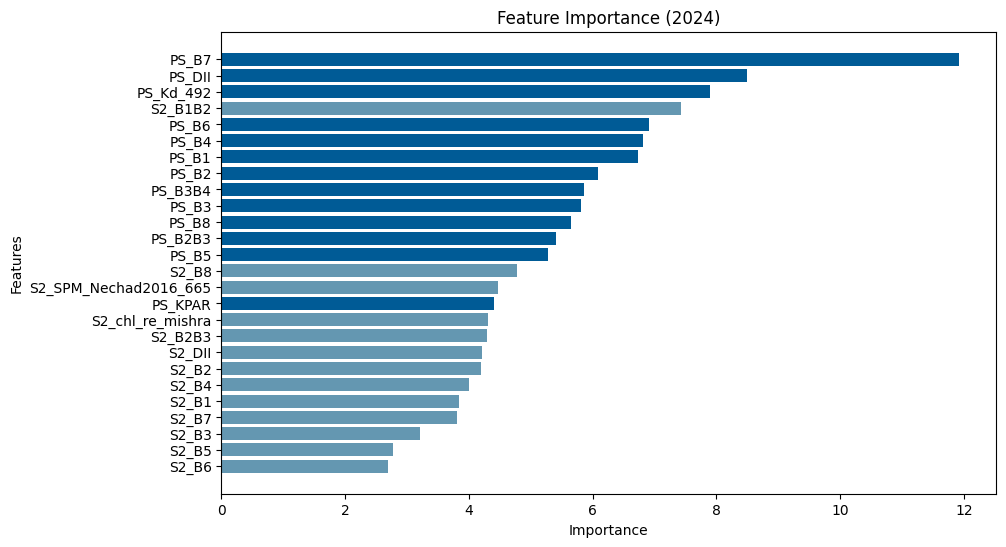

Selected bands: ['PS_B1', 'PS_B2', 'PS_B2B3', 'PS_B3', 'PS_B3B4', 'PS_B4', 'PS_B5', 'PS_B6', 'PS_B7', 'PS_B8', 'PS_DII', 'PS_KPAR', 'PS_Kd_492', 'S2_B1', 'S2_B1B2', 'S2_B2', 'S2_B2B3', 'S2_B3', 'S2_B4', 'S2_B5', 'S2_B6', 'S2_B7', 'S2_B8', 'S2_DII', 'S2_SPM_Nechad2016_665', 'S2_chl_re_mishra']


<Figure size 640x480 with 0 Axes>

In [ ]:
## To extract feature importance and evaluate
def soft_prob_subfn(image, num):
       training = sampledData.map(lambda ft: ft.set(
        'prob',
        ee.Algorithms.If(ft.getNumber('habitat').eq(num), 1, 0)
        ))

       trained = ee.Classifier.smileRandomForest(numberOfTrees=trees) \
           .train(training, 'prob', image.bandNames()) \
           .setOutputMode('PROBABILITY')

       dict_classifier = trained.explain()

       # Create a Feature with the dictionary as a property
       feature = ee.Feature(None, {'classifier_explanation': dict_classifier})

       # Classify and convert to percentage scale
       classified = image.classify(trained).multiply(100).toInt8()

       # Return both the classified image and the Feature with explanation
       return ee.Image(classified).set('classifier_explanation', feature)

# Map the function to your ImageCollection
seagrass_prob_IC = classificationComp_post.map(lambda img: soft_prob_subfn(img, seagrass_class))
nonSeagrass_prob_IC = classificationComp_post.map(lambda img: soft_prob_subfn(img, nonSeagrass_class))

### MEAN FEATURE IMPORTANCE
# Get the first three images from the ImageCollection
first_three_images = seagrass_prob_IC.toList(3)

# Initialize an empty dictionary to store feature importances
mean_importance = {}

# Iterate through the first three images
for i in range(3):
  image = ee.Image(first_three_images.get(i))
  classifier_explanation = image.get('classifier_explanation').getInfo()['properties']['classifier_explanation']
  importance_dict = classifier_explanation.get('importance')

  # Accumulate feature importances
  for feature, importance in importance_dict.items():
    mean_importance[feature] = mean_importance.get(feature, 0) + importance

# Calculate the mean feature importance
for feature in mean_importance:
  mean_importance[feature] /= 3

# Print the mean feature importance
print(mean_importance)

# Sort features by importance in descending order
sorted_importance = dict(sorted(mean_importance.items(), key=lambda item: item[1], reverse=False))

# Extract feature names and importance values
feature_names = list(sorted_importance.keys())
importance_values = list(sorted_importance.values())

# Create a list of colors based on feature name prefix
colors = ['#005b96' if name.startswith('PS_') else '#6497b1' for name in feature_names]

# Create the horizontal bar graph (switched axes)
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance_values, color=colors)
plt.ylabel("Features")
plt.xlabel("Importance")
plt.title("Feature Importance (2024)")
plt.show()
plt.tight_layout()

selected_bands = [band for band, importance in mean_importance.items() if importance >= 0]

print("Selected bands:", selected_bands)

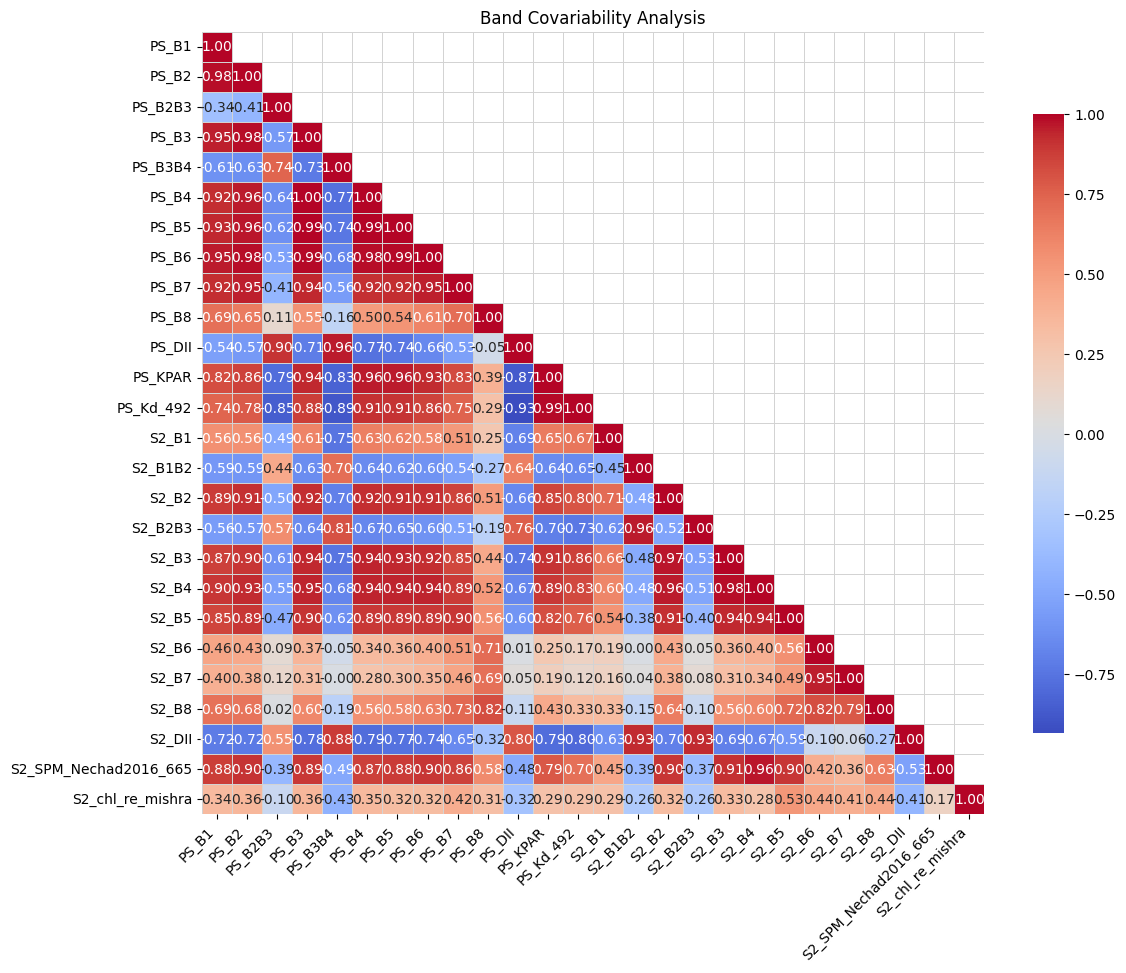

Bands to keep: ['PS_B1', 'PS_B2', 'PS_B2B3', 'PS_B3', 'PS_B3B4', 'PS_B4', 'PS_B5', 'PS_B6', 'PS_B7', 'PS_B8', 'PS_DII', 'PS_KPAR', 'PS_Kd_492', 'S2_B1', 'S2_B1B2', 'S2_B2', 'S2_B2B3', 'S2_B3', 'S2_B4', 'S2_B5', 'S2_B6', 'S2_B7', 'S2_B8', 'S2_DII', 'S2_SPM_Nechad2016_665', 'S2_chl_re_mishra']


In [ ]:
## Co-variance analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to extract band values from a FeatureCollection
def extract_band_values(feature_collection, bands):
    data = feature_collection.toList(feature_collection.size()).map(lambda feature: ee.Feature(feature).toDictionary().select(bands)).getInfo()
    df = pd.DataFrame(data)
    return df

band_values_df = extract_band_values(sampledData, selected_bands)

correlation_matrix = band_values_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, bool), k=1)

# Apply the mask to the filtered correlation matrix
filtered_correlation_matrix = correlation_matrix.mask(mask)
filtered_correlation_matrix = filtered_correlation_matrix[np.abs(correlation_matrix) > 0.80]

# Get bands with at least one correlation above 0.9
bands_to_keep = filtered_correlation_matrix.columns[filtered_correlation_matrix.any()]

# Filter the original correlation matrix to keep only relevant bands
filtered_correlation_matrix = correlation_matrix.loc[bands_to_keep, bands_to_keep]

plt.figure(figsize=(12, 10))
sns.heatmap(filtered_correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
            fmt=".2f", linewidths=.5, linecolor='lightgrey', square=True,
            cbar_kws={"shrink": .75})
plt.title('Band Covariability Analysis')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Bands to keep:", bands_to_keep.tolist())

### 6.2.3 - Generate probability layers

In [ ]:
## Train classifier and display probability map for seagrasses
# Define classes dictionary
classes = {
  'classes_values': [seagrass_class, nonSeagrass_class],
  'classes_names': ['seagrass','nonSeagrass']
}

classes

def classify_with_all_classes(image):
    # Classify image for each class and rename the result accordingly
    classified_images = ee.List(classes['classes_values']).map(
        lambda class_id: soft_prob_subfn(image, class_id)
    )

    # Convert list of images into one multi-band image (each class as band)
    classified_combined = ee.ImageCollection(classified_images).toBands()
    classified_combined = classified_combined.rename(classes['classes_names'])

    # Preserve metadata if needed
    return classified_combined.copyProperties(image, image.propertyNames())

# Generate probabilities in the ImageCollection
probabilities_post = classificationComp_post.map(classify_with_all_classes)
probabilities_post

In [ ]:
# Visualize probabilities
first_prob = ee.Image(probabilities_post.toList(probabilities_post.size()).get(0))
Map = geemap.Map()
Map.addLayer(first_prob.select('seagrass'), {'min': 45, 'max': 100}, 'Seagrass Prob')
Map.addLayer(first_prob.select('nonSeagrass'), {'min': 45, 'max': 100}, 'NonSeagrass Prob')
Map.centerObject(probabilities_post.first(), zoom=12)
Map

#### 6.2.4 - Threshold classes based on probabilities and classify

In [ ]:
# Based on the generated probabilities, apply thresholding for seagrass and nonSeagrass on the whole Image Collection

# Threshold function for seagrass
def threshold_seagrass(image):
    return image.select('seagrass').updateMask(image.select('seagrass').gt(t)) \
        .copyProperties(image, image.propertyNames())

# Threshold function for non-seagrass
def threshold_non_seagrass(image):
    return image.select('nonSeagrass').updateMask(image.select('nonSeagrass').gt(t)) \
        .copyProperties(image, image.propertyNames())

# Map the thresholding over the probabilities collection
seagrass_soft = probabilities_post.map(threshold_seagrass)
nonSeagrass_soft = probabilities_post.map(threshold_non_seagrass)
nonSeagrass_soft

# Function to combine seagrass and nonSeagrass into one image
def add_bands(image):
    matching_non_seagrass = nonSeagrass_soft.filter(
        ee.Filter.eq('system:index', image.get('system:index'))
    ).first()

    # If no match is found, return image as-is
    combined = ee.Image(image).addBands(ee.Image(matching_non_seagrass))
    return combined.copyProperties(image, image.propertyNames())

# Map the function to seagrass_soft collection to create the aggregated collection
soft_map = seagrass_soft.map(add_bands)
soft_map

#### 6.2.5 - Perform classification

In [ ]:
def soft_to_hard(image):
    seagrass = image.select('seagrass')
    non_seagrass = image.select('nonSeagrass')
    prob_aoi = ee.Image(probabilities_post.first()).geometry()

    # Get the corresponding images from seagrass_soft and nonSeagrass_soft using system:index
    seagrass_soft_image = seagrass_soft.filter(ee.Filter.eq('system:index', image.get('system:index'))).first()
    nonSeagrass_soft_image = nonSeagrass_soft.filter(ee.Filter.eq('system:index', image.get('system:index'))).first()

    classified = (ee.Image.constant(2)
        .where(seagrass.gte(t), ee.Number(0).add(1))  # temporary +1 to mask 0s
        .where(non_seagrass.gte(t), ee.Number(1).add(1))
        .selfMask()
        .subtract(1)  # back to 0 and 1
        .rename('classification')
        .clip(prob_aoi))

    return classified.copyProperties(image, image.propertyNames())

# Apply to soft_map
soft_map_th = soft_map.map(soft_to_hard)
soft_map_th

#### 6.2.6 - Combine the three classifications for visualization

In [ ]:
# 1. Extract the classification band from each image
classification_images_post = soft_map_th.select('classification')

# 2. Calculate the mean value
combined_classification_post = classification_images_post.mean().mask(land_mask).clip(OSW)
# print(combined_classification.getInfo())

Map.addLayer(combined_classification_post, {'min': 0, 'max': 1, 'palette': ['42762f', '7cb75a', 'e2e9ab', 'ffffff']}, 'Combined Classification')
Map

In [ ]:
# # Export the FeatureCollection to Google Drive
# task = ee.batch.Export.image.toDrive(
#     image=combined_classification_post,
#     description='combined_classification_post',  # Description for the task
#     folder='Colab_Notebooks/export',
#     region = OSW.geometry(),
#     scale=3,  # Adjust the scale as needed
#     fileFormat='GeoTIFF'  # Choose your desired file format (CSV, GeoJSON, KML, SHP, TFRecord)
# )

# # Start the export task
# task.start()

# print('Export task started. You can monitor its progress in the "Tasks" tab.')

In [ ]:
# Apply conditional classification for obtain the final binary map
final_classification_post = combined_classification_post.expression(
    'b(0) < 0.35 ? 0 : 1',  # Conditional expression
    {'classification': combined_classification_post}  # Band name mapping
).rename('classification')  # Rename the band

# Display the combined classification
Map.addLayer(final_classification_post.mask(land_mask).clip(OSW.geometry()), {'min': 0, 'max': 1, 'palette': ['42762f', 'ffffff']}, 'Combined Classification')
Map

In [ ]:
final_classification_post

#### 6.2.7 - Validation and accuracy assessment for each of the 3 classifications

In [ ]:
# Validation function
def valid_habitat(number):
  def wrap(feature):
    return feature.setMulti(ee.Dictionary.fromLists(['habitat'], [number]))
  return wrap

## Validation data
v_seagrass = v_seagrass_post.map(valid_habitat(seagrass_class))
v_nonSeagrass = v_nonSeagrass_post.map(valid_habitat(nonSeagrass_class))
v_FC = v_seagrass.merge(v_nonSeagrass)
v_FC

In [ ]:
def validation(image):
    sampled = image.sampleRegions(
        collection=v_FC,
        properties=['habitat'],
        scale=3)
    return sampled

# Map the sampling function and convert result to a list of FeatureCollections
sampled_v_list = soft_map_th.map(validation).toList(soft_map_th.size())

# Flatten the FeatureCollections into one big FeatureCollection
sampledValidation_post = ee.FeatureCollection(sampled_v_list).flatten()

# Using sampleRegions we take values across the Image Collection. getting valid FeatureCollection when overlapping with pixels
print('sampled Validation:', sampledValidation_post.size().getInfo())
sampledValidation_post

sampled Validation: 93


Confusion Matrix: [[27, 27], [7, 32]]


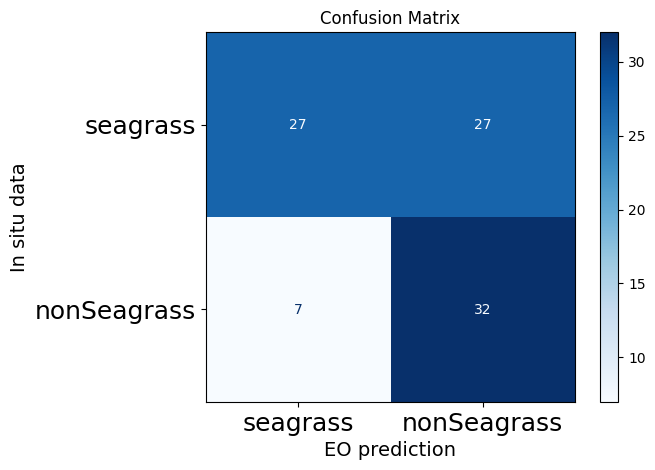

Overall Accuracy: 0.6344086021505376
PA: [0.5, 0.8205128205128205]
UA: [0.7941176470588235, 0.5423728813559322]
F1-score: 0.6136363636363636


In [ ]:
errorMatrix = sampledValidation_post.errorMatrix('habitat', 'classification')
print('Confusion Matrix:', errorMatrix.getInfo())

confusion_matrix_data = errorMatrix.array().getInfo()

# Convert the list to a NumPy array
matrix_values = np.array(confusion_matrix_data)  # Convert to NumPy array

# Define class labels
class_names = ['seagrass', 'nonSeagrass']

# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=matrix_values, display_labels=class_names)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel("EO prediction", fontsize = 14)
plt.ylabel("In situ data", fontsize = 14)
disp.ax_.tick_params(axis='both', which='major', labelsize=18)
plt.show()

overall_accuracy = errorMatrix.accuracy().getInfo()
print('Overall Accuracy:', overall_accuracy)
producers_accuracy = ee.Array(errorMatrix.producersAccuracy()).reshape([-1]).getInfo()
print('PA:', producers_accuracy)
users_accuracy = ee.Array(errorMatrix.consumersAccuracy()).reshape([-1]).getInfo()
print('UA:', users_accuracy)

# Calcuate F1-score
truePositives = errorMatrix.array().get([0, 0])
falsePositives = errorMatrix.array().get([1, 0])
falseNegatives = errorMatrix.array().get([0, 1])

# Calculate precision, recall, and F1-score
precision = truePositives.divide(truePositives.add(falsePositives))
recall = truePositives.divide(truePositives.add(falseNegatives))
f1_score = ee.Number(2).multiply(precision.multiply(recall)).divide(precision.add(recall))

print('F1-score:', f1_score.getInfo())

#### 6.1.8 - Uncertainty analysis

In [ ]:
## To run uncertainties in the first classification (pre-event, 2018)
## t=(9*OA*(3-median probabilities))/3
# 9 = area of pixel in square meters (3x3)
# 3 = number of images

## first scale probabilities to 0-1 values
def scale_to_unit(image):
    return image.divide(100).copyProperties(image, image.propertyNames())

# Apply the scaling function to the collection
probabilities_01 = probabilities.map(scale_to_unit)

median_probability = probabilities_01.select('seagrass').median().rename('seagrass_median_prob')
median_probability

# Select the band containing median probability
median_probability = median_probability.select('seagrass_median_prob')

# Apply the formula:
# uncertainty = (9 * overall_accuracy * (3 - median_probability)) / 3
three = ee.Number(3)
nine = ee.Number(9)
oa = ee.Number(overall_accuracy)

# Compute: (3 - median_prob)
diff = ee.Image.constant(1).subtract(median_probability)

# Continue: (9 * overall_accuracy * diff) / 3
# uncertainty = (diff.multiply(oa).multiply(nine)).divide(three)
uncertainty = diff.divide(oa)

# Add the uncertainty as a new band
uncertainty_post = image.addBands(uncertainty.rename('uncertainty'))

region = uncertainty_post.geometry()
# Calculate min and max of the uncertainty band
stats = uncertainty_post.select('uncertainty').reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=region,
    scale=3,
    maxPixels=1e9
)

# Get the results
min_val = stats.get('uncertainty_min').getInfo()
max_val = stats.get('uncertainty_max').getInfo()

print('Uncertainty range:', min_val, 'to', max_val)


# ###########################

# Select the uncertainty band
uncertainty_post = uncertainty_post.select('uncertainty')

# Normalize to 0–1
normalized_uncertainty = uncertainty_post.subtract(min_val).divide(max_val - min_val)

# Add it back to the image
overlap_mask = combined_classification_post.mask().reduce(ee.Reducer.anyNonZero())
uncertainty_post_norm = image.addBands(normalized_uncertainty.rename('uncertainty_norm'))

region = uncertainty_pre_norm.geometry()
# Calculate min and max of the uncertainty band
stats2 = uncertainty_post_norm.select('uncertainty_norm').reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=region,
    scale=3,
    maxPixels=1e9
)

# Get the results
min_val = stats2.get('uncertainty_norm_min').getInfo()
max_val = stats2.get('uncertainty_norm_max').getInfo()

print('Uncertainty range norm:', min_val, 'to', max_val)

# Visualize the mean uncertainty layer
# Define visualization parameters for the uncertainty band
# You may need to adjust the min/max values based on your data range
vis_params = {'bands': ['uncertainty_norm'], 'palette': ['#4d004b', '#4f004d', '#50014e', '#520150', '#540251', '#550253', '#570354', '#580356', '#5a0457', '#5c0459', '#5d055a', '#5f055c', '#61065d', '#62065f', '#640761', '#650762', '#670864', '#690865', '#6a0867', '#6c0968', '#6e096a', '#6f0a6b', '#710a6d', '#730b6e', '#740b70', '#760c71', '#770c73', '#790d75', '#7b0d76', '#7c0e78', '#7e0e79', '#800f7b', '#810f7c', '#81117d', '#81127e', '#82147f', '#821580', '#821781', '#821982', '#831a83', '#831c84', '#831d85', '#831f86', '#832088', '#842289', '#84248a', '#84258b', '#84278c', '#85288d', '#852a8e', '#852b8f', '#852d90', '#852f91', '#863092', '#863293', '#863394', '#863595', '#873696', '#873897', '#873a98', '#873b99', '#873d9a', '#883e9b', '#88409c', '#88419d', '#88439e', '#88449e', '#88459f', '#8947a0', '#8948a0', '#8949a1', '#894ba2', '#894ca2', '#894da3', '#894fa3', '#8950a4', '#8a51a5', '#8a52a5', '#8a54a6', '#8a55a7', '#8a56a7', '#8a58a8', '#8a59a8', '#8a5aa9', '#8b5caa', '#8b5daa', '#8b5eab', '#8b60ac', '#8b61ac', '#8b62ad', '#8b64ad', '#8b65ae', '#8c66af', '#8c68af', '#8c69b0', '#8c6ab1', '#8c6cb1', '#8c6db2', '#8c6eb3', '#8c70b3', '#8c71b4', '#8c72b5', '#8c74b5', '#8c75b6', '#8c76b7', '#8c78b7', '#8c79b8', '#8c7ab8', '#8c7cb9', '#8c7dba', '#8c7eba', '#8c80bb', '#8c81bc', '#8c82bc', '#8c84bd', '#8c85be', '#8c86be', '#8c88bf', '#8c89c0', '#8c8bc0', '#8c8cc1', '#8c8dc2', '#8c8fc2', '#8c90c3', '#8c91c4', '#8c93c4', '#8c94c5', '#8c95c6', '#8c97c6', '#8d98c7', '#8d99c8', '#8e9ac8', '#8f9bc9', '#8f9dc9', '#909eca', '#909fcb', '#91a0cb', '#91a1cc', '#92a3cd', '#92a4cd', '#93a5ce', '#94a6ce', '#94a7cf', '#95a8d0', '#95aad0', '#96abd1', '#96acd2', '#97add2', '#98aed3', '#98b0d3', '#99b1d4', '#99b2d5', '#9ab3d5', '#9ab4d6', '#9bb6d7', '#9cb7d7', '#9cb8d8', '#9db9d9', '#9dbad9', '#9ebcda', '#9fbcda', '#a0bddb', '#a1bedb', '#a2bfdb', '#a3bfdc', '#a4c0dc', '#a5c1dc', '#a6c2dd', '#a7c2dd', '#a8c3de', '#a9c4de', '#aac4de', '#abc5df', '#acc6df', '#adc7e0', '#aec7e0', '#afc8e0', '#b0c9e1', '#b1c9e1', '#b2cae1', '#b3cbe2', '#b4cce2', '#b5cce3', '#b6cde3', '#b7cee3', '#b9cee4', '#bacfe4', '#bbd0e4', '#bcd1e5', '#bdd1e5', '#bed2e6', '#bfd3e6', '#c0d4e6', '#c1d4e7', '#c2d5e7', '#c3d6e8', '#c4d7e8', '#c5d8e9', '#c6d8e9', '#c7d9e9', '#c8daea', '#c9dbea', '#cadbeb', '#cbdceb', '#ccddec', '#cddeec', '#cedfec', '#cfdfed', '#d0e0ed', '#d1e1ee', '#d2e2ee', '#d3e2ef', '#d4e3ef', '#d6e4f0', '#d7e5f0', '#d8e6f0', '#d9e6f1', '#dae7f1', '#dbe8f2', '#dce9f2', '#ddeaf3', '#deeaf3', '#dfebf4', '#e0ecf4', '#e1ecf4', '#e1edf5', '#e2edf5', '#e3eef5', '#e4eef5', '#e4eff6', '#e5eff6', '#e6f0f6', '#e6f0f7', '#e7f1f7', '#e8f1f7', '#e9f2f7', '#e9f2f8', '#eaf3f8', '#ebf3f8', '#ebf4f8', '#ecf4f9', '#edf5f9', '#eef5f9', '#eef6fa', '#eff6fa', '#f0f7fa', '#f1f7fa', '#f1f8fb', '#f2f8fb', '#f3f9fb', '#f3f9fc', '#f4fafc', '#f5fafc', '#f6fbfc', '#f6fbfd', '#f7fcfd'], 'min': 0, 'max': 1}
Map = geemap.Map()
Map.addLayer(uncertainty_post_norm.select('uncertainty_norm'), vis_params, "Uncertainty Post-event")
Map.centerObject(OSW, 13)
Map

In [ ]:
# # Export the FeatureCollection to Google Drive
# task = ee.batch.Export.image.toDrive(
#     image=uncertainty_post_norm.toFloat(),
#     description='uncertainty_post_norm',  # Description for the task
#     folder='Colab_Notebooks/export',
#     region = OSW.geometry(),
#     scale=3,  # Adjust the scale as needed
#     fileFormat='GeoTIFF'  # Choose your desired file format (CSV, GeoJSON, KML, SHP, TFRecord)
# )

# # Start the export task
# task.start()

# print('Export task started. You can monitor its progress in the "Tasks" tab.')

### Area quantification and +-

In [ ]:
# Mask seagrass pixels
seagrass_post = final_classification_post.eq(0)

# create a binary mask: 1 = seagrass, 0 = not
seagrass_mask = seagrass_post.rename('seagrass')  # change eq(0) if your seagrass label differs

# count seagrass pixels (sum of 1s)
pixel_count = seagrass_mask.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=OSW.geometry(),
    scale=3, # 3 m pixels
    maxPixels=1e13
).get('seagrass').getInfo()

# convert to hectares: each pixel = 9 m2 -> 9/10000 = 0.0009 ha
area_ha_post = pixel_count * 9.0 / 10000.0

print(f"Seagrass pixels: {pixel_count}, area: {area_ha_post} ha")

Seagrass pixels: 32555.67058823529, area: 29.300103529411764 ha


In [ ]:
# Scale probabilities from 0-100 to 0-1
probabilities_post = probabilities_post.map(lambda image: image.divide(100))

# Sum the seagrass probabilities for pre-event images
sum_seagrass_probabilities_post = probabilities_post.select('seagrass').sum()
sum_seagrass_probabilities_post

# Calculate the mean of the summed probabilities within the seagrass mask
mean_sum_prob_seagrass_post = sum_seagrass_probabilities_post.updateMask(seagrass_mask).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=OSW.geometry(),
    scale=3, # Use the same scale as classification
    maxPixels=1e13
).get('seagrass')

mean_sum_prob_seagrass_post = ee.Number(mean_sum_prob_seagrass_post)

overall_accuracy_post = ee.Number(overall_accuracy) # Use the overall_accuracy from the pre-event validation cell

# Get the total seagrass area for the pre-event classification (assuming it's stored in area_ha variable from cell ZfHt_UQ49oKf)
# If not, you might need to recalculate it here or fetch it from the appropriate variable.
total_seagrass_area_post = ee.Number(area_ha_post)


# Calculate uncertainty for the pre-event seagrass area using the provided formula:
# uncertainty = area * Overall Accuracy * (3 - mean of the sum of the probabilities predicted as seagrass) / 3
# Assuming '3' is the number of images used in the pre-event period (sentinel2_l1c_pre has 3 images)
num_images_post = ee.Number(sentinel2_l1c_post.size()) # Get the actual number of pre-event images

uncertainty_post_seagrass_area = total_seagrass_area_post.multiply(overall_accuracy_post).multiply(num_images_post.subtract(mean_sum_prob_seagrass_post)).divide(num_images_post)

print(f"Uncertainty of post-event seagrass area: {area_ha_post} +- {uncertainty_post_seagrass_area.getInfo():.2f} ha")

Uncertainty of post-event seagrass area: 29.300103529411764 +- 22.97 ha


# 7 - Seagrass change detection

In [ ]:
seagrass_pre = final_classification_pre.updateMask(final_classification_pre.select('classification').eq(0))
seagrass_post = final_classification_post.updateMask(final_classification_post.select('classification').eq(0))

In [ ]:
# Change from 0 to 1 (e.g., newly appeared features)
gain = final_classification_pre.eq(1).And(final_classification_post.eq(0)).rename('gain')

# Change from 1 to 0 (e.g., disappeared features)
loss = final_classification_pre.eq(0).And(final_classification_post.eq(1)).rename('loss')

# Stable seagrass meadows
stable = final_classification_pre.eq(0).And(final_classification_post.eq(0)).rename('stable')

# Combine the conditions into a single image using 'where'
seagrass_change = ee.Image(0) \
    .where(loss, 1) \
    .where(stable, 2) \
    .where(gain, 3)

seagrass_change
gain

In [ ]:
# count seagrass pixels (sum of 1s)
pixel_count_loss = loss.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=OSW.geometry(),
    scale=3, # 3 m pixels
    maxPixels=1e13
).get('loss').getInfo()

# convert to hectares: each pixel = 9 m2 -> 9/10000 = 0.0009 ha
area_ha_loss = pixel_count_loss * 9.0 / 10000.0

# count seagrass pixels (sum of 1s)
pixel_count_gain = gain.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=OSW.geometry(),
    scale=3, # 3 m pixels
    maxPixels=1e13
).get('gain').getInfo()

# convert to hectares: each pixel = 9 m2 -> 9/10000 = 0.0009 ha
area_ha_gain = pixel_count_gain * 9.0 / 10000.0

# count seagrass pixels (sum of 1s)
pixel_count_stable = stable.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=OSW.geometry(),
    scale=3, # 3 m pixels
    maxPixels=1e13
).get('stable').getInfo()

# convert to hectares: each pixel = 9 m2 -> 9/10000 = 0.0009 ha
area_ha_stable = pixel_count_stable * 9.0 / 10000.0

print(f"Seagrass lost: {pixel_count_loss}, area: {area_ha_loss} ha")
print(f"Seagrass gained: {pixel_count_gain}, area: {area_ha_gain} ha")
print(f"Seagrass stable: {pixel_count_stable}, area: {area_ha_stable} ha")


Seagrass lost: 239482.67843137257, area: 215.53441058823532 ha
Seagrass gained: 12064.533333333331, area: 10.858079999999998 ha
Seagrass stable: 20491.137254901965, area: 18.442023529411767 ha


In [ ]:
num_images_pre = ee.Number(sentinel2_l1c_pre.size()) # Get the actual number of pre-event images

# Sum the seagrass probabilities for pre-event images
sum_seagrass_probabilities_post = probabilities_post.select('seagrass').sum()
sum_seagrass_probabilities_pre = probabilities_pre.select('seagrass').sum()
sum_seagrass_probabilities_mean = sum_seagrass_probabilities_pre.add(sum_seagrass_probabilities_post).divide(2)

# Calculate the mean of the summed probabilities within the seagrass mask
mean_sum_prob_seagrass_mean = sum_seagrass_probabilities_mean.updateMask(gain).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=OSW.geometry(),
    scale=3, # Use the same scale as classification
    maxPixels=1e13
).get('seagrass')

mean_sum_prob_seagrass_mean_gain = ee.Number(mean_sum_prob_seagrass_mean)

OA_change = overall_accuracy_pre.add(overall_accuracy_post).divide(2)

uncertainty_post_seagrass_gain = ee.Number(area_ha_gain).multiply(ee.Number(OA_change)).multiply(num_images_pre.subtract(mean_sum_prob_seagrass_mean_gain)).divide(num_images_pre)

print(f"Uncertainty gain seagrass: {area_ha_gain} +- {uncertainty_post_seagrass_gain.getInfo():.2f} ha")

Uncertainty gain seagrass: 10.858079999999998 +- 6.80 ha


In [ ]:
# Calculate the mean of the summed probabilities within the seagrass mask
mean_sum_prob_seagrass_mean = sum_seagrass_probabilities_mean.updateMask(loss).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=OSW.geometry(),
    scale=3, # Use the same scale as classification
    maxPixels=1e13
).get('seagrass')

mean_sum_prob_seagrass_mean_loss = ee.Number(mean_sum_prob_seagrass_mean)

uncertainty_post_seagrass_loss = ee.Number(area_ha_loss).multiply(ee.Number(OA_change)).multiply(num_images_pre.subtract(mean_sum_prob_seagrass_mean_loss)).divide(num_images_pre)

print(f"Uncertainty loss seagrass: {area_ha_loss} +- {uncertainty_post_seagrass_loss.getInfo():.2f} ha")

Uncertainty loss seagrass: 215.53441058823532 +- 113.03 ha


In [ ]:
# Calculate the mean of the summed probabilities within the seagrass mask
mean_sum_prob_seagrass_mean = sum_seagrass_probabilities_mean.updateMask(stable).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=OSW.geometry(),
    scale=3, # Use the same scale as classification
    maxPixels=1e13
).get('seagrass')

mean_sum_prob_seagrass_mean_stable = ee.Number(mean_sum_prob_seagrass_mean)

uncertainty_post_seagrass_stable = ee.Number(area_ha_stable).multiply(ee.Number(OA_change)).multiply(num_images_pre.subtract(mean_sum_prob_seagrass_mean_stable)).divide(num_images_pre)

print(f"Uncertainty stable seagrass: {area_ha_stable} +- {mean_sum_prob_seagrass_mean_stable.getInfo():.2f} ha")

Uncertainty stable seagrass: 18.442023529411767 +- 1.03 ha
